# Análise Exploratória de Preços de Combustíveis e Variáveis Macroeconômicas


# Introdução

Os preços dos combustíveis afetam diretamente a economia, influenciando o custo do transporte, logística e inflação.  
Este estudo visa desenvolver um modelo preditivo para antecipar variações e auxiliar na tomada de decisões estratégicas.

A seguir, exploramos os dados históricos, identificamos padrões e aplicamos modelos de Machine Learning para prever os preços dos combustíveis no Brasil.


## Objetivos:
- Identificar padrões sazonais e regionais nos preços dos combustíveis.
- Analisar correlações com variáveis macroeconômicas, como câmbio e inflação.
- Preparar os dados para modelagem preditiva.

---


# Coleta de Dados

Os dados foram coletados a partir das seguintes fontes:

- **ANP (Agência Nacional do Petróleo, Gás Natural e Biocombustíveis)** - preços de revenda.
- **Banco Central e IBGE** - variáveis macroeconômicas (inflação, câmbio, PIB).
- **Outras fontes econômicas** - eventos que impactam o setor de combustíveis.

### Processamento Inicial:
- Remoção de valores ausentes e inconsistentes.
- Conversão de formatos de data e preços.
- Identificação de outliers e possíveis ajustes.

---


Este notebook realiza uma **análise exploratória completa** dos preços dos combustíveis e sua relação com variáveis macroeconômicas. Também analisamos quais colunas devem ser mantidas ou removidas, utilizando **estatísticas descritivas, gráficos e testes estatísticos**.

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook: ', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook:  3.12.1


# 0.0. Importando

In [2]:
# Importação de Bibliotecas
import os
import re
import io
import pickle
import joblib
import warnings
import numpy as np
import pandas as pd
import shap
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from pathlib import Path
from IPython.core.display import display, HTML
from boruta import BorutaPy

from sklearn.model_selection import (
    train_test_split, 
    TimeSeriesSplit, 
    RandomizedSearchCV
)
from sklearn.metrics import (
    mean_absolute_percentage_error,
    mean_absolute_error, 
    mean_squared_error, 
    r2_score
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import (
    OneHotEncoder, 
    LabelEncoder, 
    RobustScaler, 
    MinMaxScaler, 
    StandardScaler
)
from xgboost import XGBRegressor

# Configuração de estilo dos gráficos
sns.set_style("whitegrid")


c:\Users\sydne\OneDrive\Pessoal\workspace\fuel_price_predictor\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\sydne\AppData\Local\Temp\ipykernel_27292\51664525.py:18: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


## 0.1. Helper Functions

In [3]:
from turtle import title

warnings.filterwarnings('ignore')

def jupyter_settings():
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 13]
    plt.rcParams['font.size'] = 24
    display(HTML('<style>.container {width:100% !important; } </style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.float_format', lambda x: '%.4f' % x)
    sns.set()


# Função para calcular métricas de erro dos modelos
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    return pd.DataFrame({
        'Model Name': [model_name],
        'MAE': [mae],
        'RMSE': [rmse]
    })


# Função para treinar e avaliar um modelo
def avaliar_modelo(features, nome_modelo):
    df_model = df_final_00.dropna(subset=features + ['valor_de_venda'])
    X = df_model[features]
    y = df_model['valor_de_venda']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    results = {
        'Modelo': nome_modelo,
        'R² Treino': r2_score(y_train, y_pred_train),
        'R² Teste': r2_score(y_test, y_pred_test),
        'RMSE Treino': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'RMSE Teste': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'MAE Treino': mean_absolute_error(y_train, y_pred_train),
        'MAE Teste': mean_absolute_error(y_test, y_pred_test)
    }
    
    return results


# Função para calcular o Erro Percentual Médio (MPE)
def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)


# Função para transformar os nomes
def renomear_coluna(nome):
    nome = nome.lower()  # Converte para minúsculas
    nome = re.sub(r'[^a-z0-9]+', '_', nome)  # Substitui espaços e caracteres especiais por "_"
    nome = nome.strip('_')  # Remove "_" extras no início ou fim
    return nome


def analisar_colunas_vazias(df):
    """
    Analisa um DataFrame e retorna um relatório sobre colunas com valores ausentes,
    colunas completamente vazias e a porcentagem de valores nulos.

    Parâmetros:
    df (pd.DataFrame): DataFrame a ser analisado.

    Retorno:
    pd.DataFrame: DataFrame com o relatório de análise.
    """
    # Contagem de valores nulos
    nulos = df.isnull().sum()

    # Porcentagem de valores nulos
    porcentagem_nulos = (nulos / len(df)) * 100

    # Colunas completamente vazias (todas as linhas são NaN)
    colunas_totalmente_vazias = df.columns[df.isnull().all()].tolist()

    # Colunas que possuem pelo menos um valor nulo
    colunas_parcialmente_vazias = df.columns[df.isnull().any()].tolist()

    # Colunas que têm apenas um único valor (pode ser um indicativo de irrelevância)
    colunas_unicas = df.nunique()
    colunas_constantes = colunas_unicas[colunas_unicas == 1].index.tolist()

    # Criando um DataFrame com o relatório
    relatorio = pd.DataFrame({
        'Coluna': df.columns,
        'Valores Nulos': nulos.values,
        'Porcentagem de Nulos (%)': porcentagem_nulos.values,
        '100% Vazia': df.columns.isin(colunas_totalmente_vazias),
        'Possui Nulos': df.columns.isin(colunas_parcialmente_vazias),
        'Valor Único (Possível Constante)': df.columns.isin(colunas_constantes)
    })

    return relatorio


def analisar_qualidade_dados(df):
    """
    Analisa a qualidade dos dados em um DataFrame, verificando:
    - Strings vazias ("") e espaços (" ")
    - Linhas duplicadas
    - Distribuição dos valores únicos por coluna

    Parâmetros:
    df (pd.DataFrame): DataFrame a ser analisado.

    Retorno:
    pd.DataFrame: DataFrame com o relatório de análise.
    """
    # Contagem de strings vazias ("") e espaços em branco (" ")
    vazios = (df == "").sum()
    espacos = (df == " ").sum()

    # Contagem de valores únicos por coluna
    valores_unicos = df.nunique()

    # Verificar a quantidade de linhas duplicadas no DataFrame
    linhas_duplicadas = df.duplicated().sum()

    # Criando um DataFrame com o relatório
    relatorio = pd.DataFrame({
        'Coluna': df.columns,
        'Valores Vazios ("")': vazios.values,
        'Espaços em Branco (" ")': espacos.values,
        'Valores Únicos': valores_unicos.values
    })

    print(f"Linhas Duplicadas no DataFrame: {linhas_duplicadas}")

    return relatorio


# Criar função para calcular os estatísticos
def resumo_boxplot(df, group_col):
    return df.groupby(group_col)['valor_de_venda'].agg(
        Minimo='min',
        Q1=lambda x: x.quantile(0.25),
        Mediana='median',
        Q3=lambda x: x.quantile(0.75),
        Maximo='max',
        Media='mean',
        Desvio_Padrao='std'
    ).reset_index()


def analisar_distribuicao_precos_por_produto(df, coluna_preco='valor_de_venda', coluna_produto='produto'):
    """
    Gera um gráfico de distribuição (histograma + KDE) e uma tabela de frequência para análise dos preços dos combustíveis.

    Parâmetros:
    - df: DataFrame contendo os dados.
    - coluna_preco: Nome da coluna que contém os preços dos combustíveis.
    - coluna_produto: Nome da coluna que contém os tipos de combustíveis.
    - titulo: Título do gráfico.

    Retorno:
    - Exibe o gráfico de distribuição dos preços.
    - Exibe uma tabela de frequência das faixas de preços.
    """
    # Criar o gráfico de distribuição dos preços por tipo de combustível

    # Criar um gráfico de distribuição para cada tipo de combustível
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df, x='valor_de_venda', hue='produto', bins=30, kde=True)

    # Adicionar título e labels
    plt.title('Distribuição dos Preços dos Combustíveis (Apenas 2023-2024)')
    plt.xlabel('Preço de Venda (R$)')
    plt.ylabel('Frequência')

    # Mostrar o gráfico
    plt.show()

    # Definir os intervalos de preços
    bins = np.arange(df[coluna_preco].min(), df[coluna_preco].max() + 0.5, 0.5)  # Intervalos de 0.50 reais
    labels = [f"{round(bins[i],2)} - {round(bins[i+1],2)}" for i in range(len(bins)-1)]

    # Criar DataFrame para armazenar os resultados
    tabela_frequencia = pd.DataFrame()

    # Loop por cada produto e calcular frequência
    for produto in df[coluna_produto].unique():
        df_produto = df[df[coluna_produto] == produto].copy()
        df_produto['Faixa_Preco'] = pd.cut(df_produto[coluna_preco], bins=bins, labels=labels, include_lowest=True)
        freq_produto = df_produto['Faixa_Preco'].value_counts().sort_index().reset_index()
        freq_produto.columns = ['Faixa de Preço (R$)', f'Frequência ({produto})']

        # Converter 'Faixa de Preço (R$)' para string para evitar erro do Pandas
        freq_produto['Faixa de Preço (R$)'] = freq_produto['Faixa de Preço (R$)'].astype(str)

        # Juntar os resultados na tabela final
        if tabela_frequencia.empty:
            tabela_frequencia = freq_produto
        else:
            tabela_frequencia = tabela_frequencia.merge(freq_produto, on="Faixa de Preço (R$)", how="outer")

    # Preencher valores nulos com zero e converter colunas numéricas para inteiros
    tabela_frequencia = tabela_frequencia.fillna(0)
    for col in tabela_frequencia.columns[1:]:  # Evita converter a coluna de faixa de preço
        tabela_frequencia[col] = tabela_frequencia[col].astype(int)

    # Exibir a tabela interativa
    display(tabela_frequencia)

    

In [4]:
jupyter_settings()

# Criar diretório se não existir
model_dir = "../data/models/"
os.makedirs(model_dir, exist_ok=True)

## 0.2. Carregamento dos Dados

In [5]:
# Caminho para o diretório acima do atual
BASE_DIR = Path("..")  # Sobe um nível na hierarquia de diretórios

# Caminho para o diretório "data/processed/" dentro do diretório acima
DATA_DIR = BASE_DIR / "data" / "processed"

# Definir os caminhos dos arquivos
file_paths = {
    "macroeconomic_data": DATA_DIR / "macroeconomic_data.csv",
    "precos_combustiveis_unificado": DATA_DIR / "precos_combustiveis_unificado.csv",
}

# Carregar os datasets
dfs = {name: pd.read_csv(path, encoding="utf-8", delimiter=",") for name, path in file_paths.items()}

# Separar os datasets
df_macro = dfs["macroeconomic_data"]
df_combustiveis = dfs["precos_combustiveis_unificado"]

--- 
# Dicionário de Dados

##  Valor de Venda dos Combustíveis

| Nome da Coluna           | Tipo de Dado  | Descrição |
|--------------------------|--------------|-----------|
| **Regiao - Sigla**       | String (2)   | Sigla da região do Brasil onde a revenda está localizada. |
| **Estado - Sigla**       | String (2)   | Sigla da unidade federativa (UF) onde a revenda está localizada. |
| **Municipio**            | String       | Nome do município onde a revenda está localizada. |
| **Revenda**              | String       | Nome da revenda de combustíveis. |
| **CNPJ da Revenda**      | String (18)  | Cadastro Nacional da Pessoa Jurídica (CNPJ) da revenda. |
| **Nome da Rua**          | String       | Nome da rua onde a revenda está localizada. |
| **Numero Rua**           | String       | Número do endereço da revenda. Caso não tenha número, pode aparecer como "S/N". |
| **Bairro**              | String       | Nome do bairro onde a revenda está localizada. |
| **Cep**                 | String (9)   | Código de Endereçamento Postal (CEP) da revenda. |
| **Produto**             | String       | Tipo de combustível vendido (Ex: Gasolina, Etanol, Diesel, etc.). |
| **Data da Coleta**      | Data (YYYY-MM-DD) | Data em que os preços foram coletados. |
| **Valor de Venda**      | Float        | Preço do combustível no dia da coleta. |
| **Unidade de Medida**   | String       | Unidade de medida do combustível (exemplo: "R$ / litro"). |
| **Bandeira**           | String       | Nome da bandeira/distribuidora da revenda (Ex: "BRANCA", "VIBRA ENERGIA", etc.). |

**Observações:**
- A coluna `CNPJ da Revenda` segue o formato `XX.XXX.XXX/XXXX-XX`.
- A coluna `Numero Rua` pode conter valores numéricos ou `S/N` caso o número não seja informado.
- A `Bandeira` indica se a revenda é de marca própria ("BRANCA") ou vinculada a uma distribuidora específica.
- A `Data da Coleta` está no formato `YYYY-MM-DD` para facilitar análises temporais.



## Indicadores Econômicos

| Nome da Coluna  | Tipo de Dado  | Descrição |
|-----------------|--------------|-----------|
| **date**        | Data (YYYY-MM-DD) | Data correspondente às informações econômicas. |
| **taxa_usd**    | Float        | Taxa de câmbio do dólar (USD) em relação ao real (BRL) na data informada. |
| **ipca**        | Float        | Índice de Preços ao Consumidor Amplo (IPCA), que mede a inflação oficial do Brasil. Representado como percentual mensal. |
| **brent_price** | Float        | Preço do barril de petróleo tipo Brent (em dólares) na data correspondente. |
| **wti_price**   | Float        | Preço do barril de petróleo tipo WTI (West Texas Intermediate) (em dólares) na data correspondente. |
| **selic**       | Float        | Taxa Selic, taxa básica de juros do Brasil, vigente na data informada. |

**Observações:**
- A coluna `date` está no formato `YYYY-MM-DD` para facilitar análises temporais.
- A `taxa_usd` representa o valor do câmbio do dólar no dia correspondente.
- O `ipca` é um índice percentual mensal que mede a inflação oficial.
- Os preços de petróleo (`brent_price` e `wti_price`) estão em dólares americanos por barril.
- A taxa `selic` é expressa em percentual anual e influencia diretamente os juros da economia.



In [6]:
# !pip install watermark

In [7]:
# Versões dos pacotes usados
%reload_ext watermark
%watermark -a "Sidney Martins Neto" --iversion

Author: Sidney Martins Neto

joblib     : 1.4.2
statsmodels: 0.14.4
re         : 2.2.1
platform   : 1.0.8
matplotlib : 3.10.0
IPython    : 8.31.0
seaborn    : 0.13.2
shap       : 0.47.0
xgboost    : 2.1.4
sklearn    : 1.6.0
pandas     : 2.2.3
scipy      : 1.14.1
boruta     : 0.4.3
numpy      : 2.1.0



---
# 1.0. Analisando as Colunas Antes da Limpeza

In [8]:
df1_combustiveis = df_combustiveis.copy()

## 1.1. Dados dos Combustíveis

In [9]:
df1_combustiveis.head()

,Regiao - Sigla,Estado - Sigla,Municipio,Revenda,CNPJ da Revenda,Nome da Rua,Numero Rua,Bairro,Cep,Produto,Data da Coleta,Valor de Venda,Unidade de Medida,Bandeira
0,SE,SP,SOROCABA,COMPETRO COMERCIO E DISTRIBUICAO DE DERIVADOS ...,00.003.188/0001-21,RUA HUMBERTO DE CAMPOS,306,JARDIM ZULMIRA,18061-000,ETANOL,2023-01-03,3.3900,R$ / litro,BRANCA
1,SE,SP,SOROCABA,COMPETRO COMERCIO E DISTRIBUICAO DE DERIVADOS ...,00.003.188/0001-21,RUA HUMBERTO DE CAMPOS,306,JARDIM ZULMIRA,18061-000,GASOLINA,2023-01-03,4.3900,R$ / litro,BRANCA
2,NE,AL,ARAPIRACA,COMERCIAL DE COMBUSTIVEIS E LUBRIFICANTES VITA...,02.817.655/0001-82,RODOVIA AL 220 - KM 06,S/N,PLANALTO,57308-000,ETANOL,2023-01-02,3.8900,R$ / litro,VIBRA ENERGIA
3,NE,AL,ARAPIRACA,COMERCIAL DE COMBUSTIVEIS E LUBRIFICANTES VITA...,02.817.655/0001-82,RODOVIA AL 220 - KM 06,S/N,PLANALTO,57308-000,DIESEL,2023-01-02,6.4900,R$ / litro,VIBRA ENERGIA
4,NE,AL,ARAPIRACA,COMERCIAL DE COMBUSTIVEIS E LUBRIFICANTES VITA...,02.817.655/0001-82,RODOVIA AL 220 - KM 06,S/N,PLANALTO,57308-000,GASOLINA,2023-01-02,5.1400,R$ / litro,VIBRA ENERGIA


### 1.1. Rename Columns

In [10]:
# Lista de colunas original
colunas_antigas = df1_combustiveis.columns.to_list()

# Aplicando a transformação
colunas_novas = [renomear_coluna(col) for col in colunas_antigas]

# Criando um dicionário de mapeamento
mapeamento = dict(zip(colunas_antigas, colunas_novas))

# Exibindo o resultado
display(mapeamento)

df1_combustiveis = df1_combustiveis.rename(columns=mapeamento)


{'Regiao - Sigla': 'regiao_sigla',
 'Estado - Sigla': 'estado_sigla',
 'Municipio': 'municipio',
 'Revenda': 'revenda',
 'CNPJ da Revenda': 'cnpj_da_revenda',
 'Nome da Rua': 'nome_da_rua',
 'Numero Rua': 'numero_rua',
 'Bairro': 'bairro',
 'Cep': 'cep',
 'Produto': 'produto',
 'Data da Coleta': 'data_da_coleta',
 'Valor de Venda': 'valor_de_venda',
 'Unidade de Medida': 'unidade_de_medida',
 'Bandeira': 'bandeira'}

In [11]:
display(df1_combustiveis.head())

,regiao_sigla,estado_sigla,municipio,revenda,cnpj_da_revenda,nome_da_rua,numero_rua,bairro,cep,produto,data_da_coleta,valor_de_venda,unidade_de_medida,bandeira
0,SE,SP,SOROCABA,COMPETRO COMERCIO E DISTRIBUICAO DE DERIVADOS ...,00.003.188/0001-21,RUA HUMBERTO DE CAMPOS,306,JARDIM ZULMIRA,18061-000,ETANOL,2023-01-03,3.3900,R$ / litro,BRANCA
1,SE,SP,SOROCABA,COMPETRO COMERCIO E DISTRIBUICAO DE DERIVADOS ...,00.003.188/0001-21,RUA HUMBERTO DE CAMPOS,306,JARDIM ZULMIRA,18061-000,GASOLINA,2023-01-03,4.3900,R$ / litro,BRANCA
2,NE,AL,ARAPIRACA,COMERCIAL DE COMBUSTIVEIS E LUBRIFICANTES VITA...,02.817.655/0001-82,RODOVIA AL 220 - KM 06,S/N,PLANALTO,57308-000,ETANOL,2023-01-02,3.8900,R$ / litro,VIBRA ENERGIA
3,NE,AL,ARAPIRACA,COMERCIAL DE COMBUSTIVEIS E LUBRIFICANTES VITA...,02.817.655/0001-82,RODOVIA AL 220 - KM 06,S/N,PLANALTO,57308-000,DIESEL,2023-01-02,6.4900,R$ / litro,VIBRA ENERGIA
4,NE,AL,ARAPIRACA,COMERCIAL DE COMBUSTIVEIS E LUBRIFICANTES VITA...,02.817.655/0001-82,RODOVIA AL 220 - KM 06,S/N,PLANALTO,57308-000,GASOLINA,2023-01-02,5.1400,R$ / litro,VIBRA ENERGIA


## 1.2. Data Dimensions

In [12]:
print( 'Number of Rows: {}'.format(df1_combustiveis.shape[0]) )
print( 'Number of Cols: {}'.format(df1_combustiveis.shape[1]) )

Number of Rows: 1068977
Number of Cols: 14


## 1.3. Data Types

In [13]:
df1_combustiveis['data_da_coleta'] = pd.to_datetime( df1_combustiveis['data_da_coleta'] )
df1_combustiveis.dtypes

regiao_sigla                 object
estado_sigla                 object
municipio                    object
revenda                      object
cnpj_da_revenda              object
nome_da_rua                  object
numero_rua                   object
bairro                       object
cep                          object
produto                      object
data_da_coleta       datetime64[ns]
valor_de_venda              float64
unidade_de_medida            object
bandeira                     object
dtype: object

## 1.4. Check NA

In [14]:
analisar_colunas_vazias(df1_combustiveis)

,Coluna,Valores Nulos,Porcentagem de Nulos (%),100% Vazia,Possui Nulos,Valor Único (Possível Constante)
0,regiao_sigla,0,0.0000,False,False,False
1,estado_sigla,0,0.0000,False,False,False
2,municipio,0,0.0000,False,False,False
3,revenda,0,0.0000,False,False,False
4,cnpj_da_revenda,0,0.0000,False,False,False
5,nome_da_rua,0,0.0000,False,False,False
6,numero_rua,0,0.0000,False,False,False
7,bairro,0,0.0000,False,False,False
8,cep,0,0.0000,False,False,False
9,produto,0,0.0000,False,False,False


In [15]:
analisar_qualidade_dados(df1_combustiveis)

Linhas Duplicadas no DataFrame: 4


,Coluna,"Valores Vazios ("""")","Espaços em Branco ("" "")",Valores Únicos
0,regiao_sigla,0,0,5
1,estado_sigla,0,0,27
2,municipio,0,0,460
3,revenda,0,0,11041
4,cnpj_da_revenda,0,0,12440
5,nome_da_rua,0,0,7833
6,numero_rua,0,0,4053
7,bairro,0,0,5292
8,cep,0,0,9326
9,produto,0,0,3


## 1.5. Fillout NA 

 - <s>A coluna numero_rua contém 119 valores representados apenas por espaços em branco (" "), vamos substituir por 0.</s>
 - Nada encontrado na base de dados de 2023 - 2024

In [16]:
# df1_combustiveis['numero_rua'] = df1_combustiveis['numero_rua'].apply(lambda x: 0 if str(x).strip() == " " else x)
# df1_combustiveis['numero_rua'].fillna(0, inplace=True)

## 1.6. Change Types

In [17]:
# Converter 'cnpj_da_revenda' para string formatada (garantir que fique consistente)
df1_combustiveis['cnpj_da_revenda'] = df1_combustiveis['cnpj_da_revenda'].astype(str)

# Converter 'numero_rua' para int (onde possível), senão deixar como NaN
df1_combustiveis['numero_rua'] = pd.to_numeric(df1_combustiveis['numero_rua'], errors='coerce')

# Garantir que 'cep' seja string formatada para evitar perda do zero à esquerda
df1_combustiveis['cep'] = df1_combustiveis['cep'].astype(str)

# Remover "R$ / " da coluna 'unidade_de_medida' e padronizar para apenas "litro", "m³", etc.
df1_combustiveis['unidade_de_medida'] = df1_combustiveis['unidade_de_medida'].str.replace(r'R\$ / ', '', regex=True)


## 1.7. Descriptive Statistical

In [18]:
num_attributes = df1_combustiveis.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1_combustiveis.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

## 1.7.1 Numerical Attributes

In [19]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attibutes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m


,attibutes,min,max,range,mean,median,std,skew,kurtosis
0,numero_rua,0.0000,90130.0000,90130.0000,1707.2490,NaN,3691.5673,11.0886,190.6603
1,valor_de_venda,2.6300,8.1900,5.5600,5.1302,5.3900,0.9747,-0.3429,-0.9108


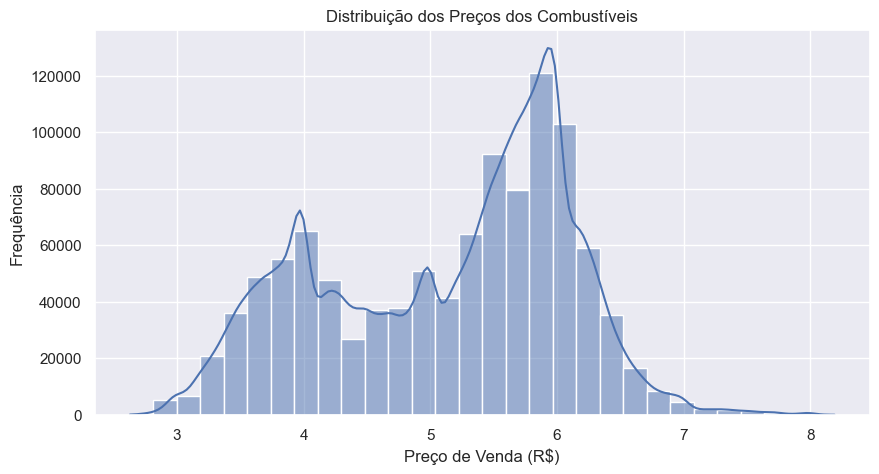

In [20]:
# Criar o gráfico de distribuição do preço do combustível
plt.figure(figsize=(10, 5))  # Ajustar o tamanho da figura
sns.histplot(x=df1_combustiveis['valor_de_venda'], bins=30, kde=True)

# Adicionar título e labels
plt.title('Distribuição dos Preços dos Combustíveis')
plt.xlabel('Preço de Venda (R$)')
plt.ylabel('Frequência')

# Mostrar o gráfico
plt.show()

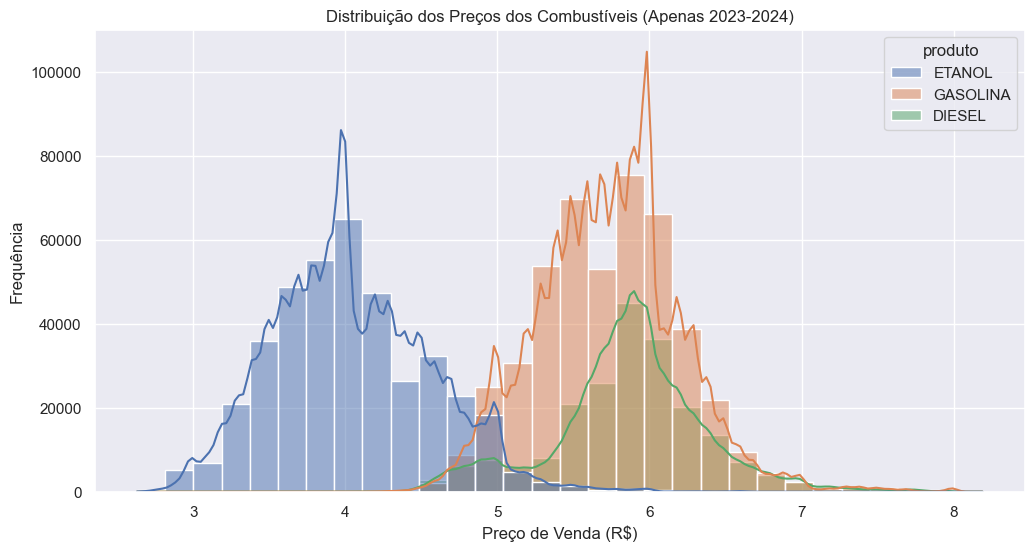

In [21]:
# Criar um gráfico de distribuição para cada tipo de combustível
plt.figure(figsize=(12, 6))
sns.histplot(data=df1_combustiveis, x='valor_de_venda', hue='produto', bins=30, kde=True)

# Adicionar título e labels
plt.title('Distribuição dos Preços dos Combustíveis (Apenas 2023-2024)')
plt.xlabel('Preço de Venda (R$)')
plt.ylabel('Frequência')

# Mostrar o gráfico
plt.show()

## 1.7.2 Categorical Attributes

In [22]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

regiao_sigla             5
estado_sigla            27
municipio              460
revenda              11041
cnpj_da_revenda      12440
nome_da_rua           7833
bairro                5292
cep                   9326
produto                  3
unidade_de_medida        1
bandeira                54
dtype: int64

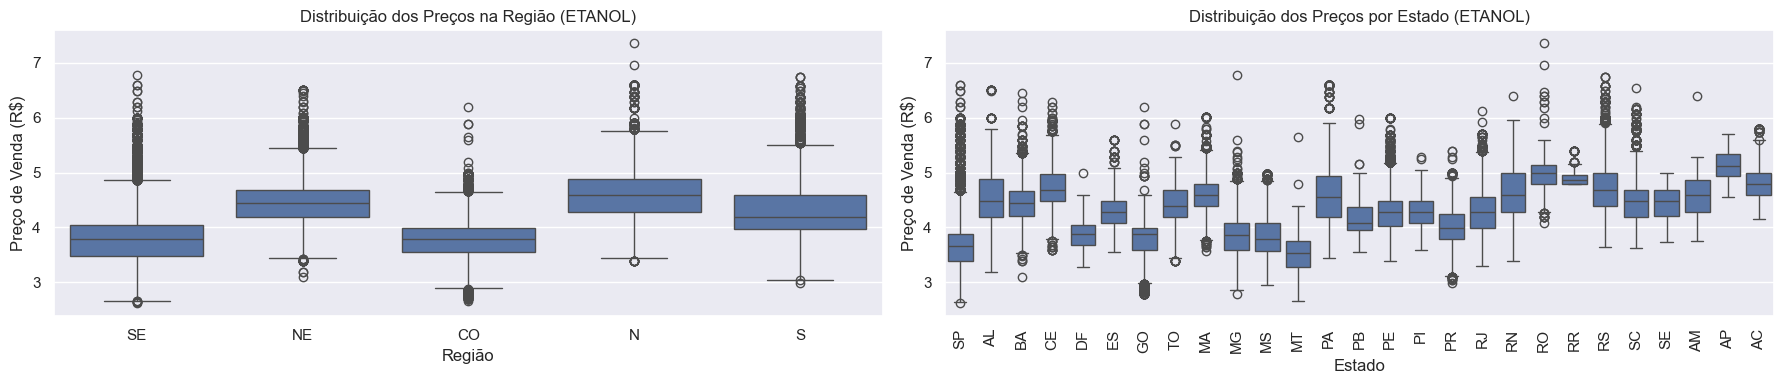

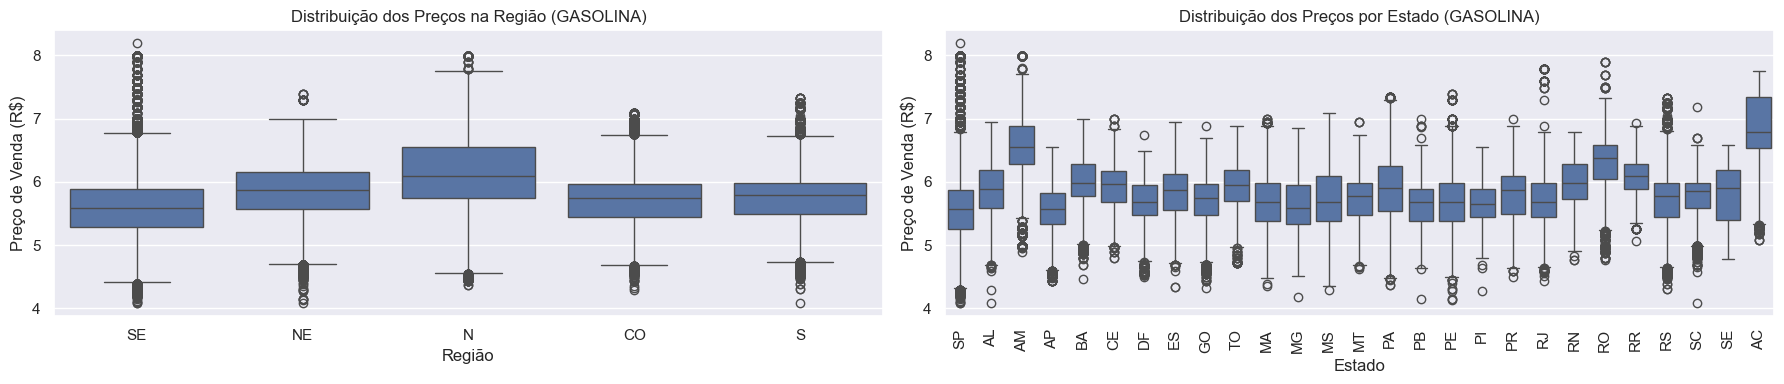

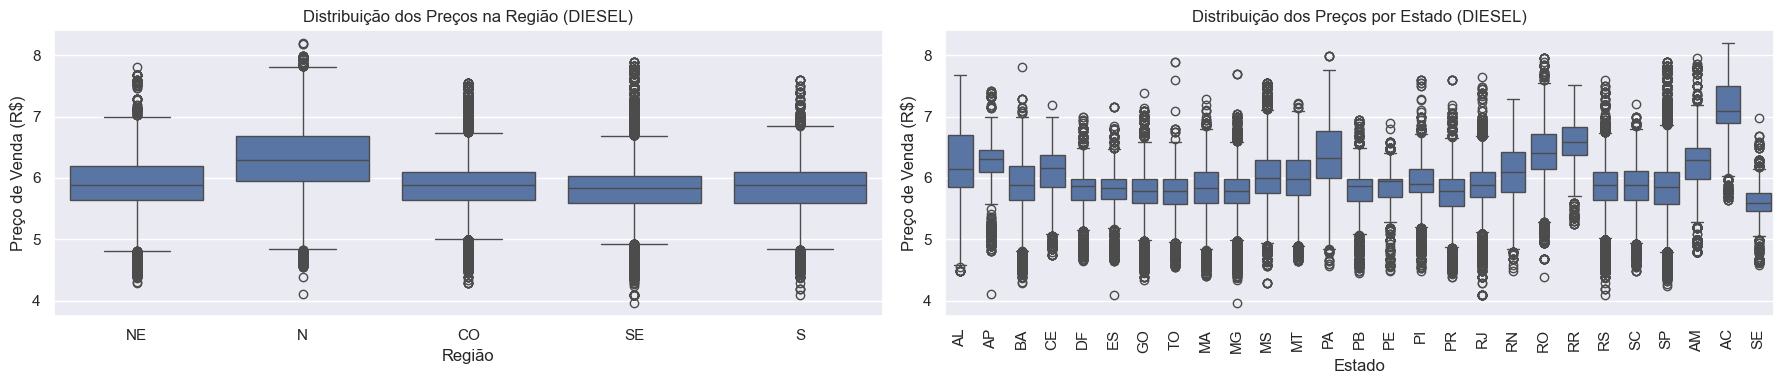

In [23]:
produtos_unicos = df1_combustiveis['produto'].unique()

for produto in produtos_unicos:
    plt.figure(figsize=(18, 4))

    df_filtrado = df1_combustiveis[df1_combustiveis['produto'] == produto]

    # Boxplot por região
    plt.subplot(1, 2, 1)
    sns.boxplot(x='regiao_sigla', y='valor_de_venda', data=df_filtrado)
    plt.title(f'Distribuição dos Preços na Região ({produto})')
    plt.xlabel('Região')
    plt.ylabel('Preço de Venda (R$)')

    # Boxplot por estado
    plt.subplot(1, 2, 2)
    sns.boxplot(x='estado_sigla', y='valor_de_venda', data=df_filtrado)
    plt.xticks(rotation=90)
    plt.title(f'Distribuição dos Preços por Estado ({produto})')
    plt.xlabel('Estado')
    plt.ylabel('Preço de Venda (R$)')

    plt.tight_layout()
    plt.show()


### 1.7.3 Análise Estatística dos Preços dos Combustíveis

In [24]:
# Criar tabelas de resumo
tabela_por_regiao = resumo_boxplot(df1_combustiveis, 'regiao_sigla')
tabela_por_estado = resumo_boxplot(df1_combustiveis, 'estado_sigla')
tabela_por_produto = resumo_boxplot(df1_combustiveis, 'produto')

#### **Análise por Região**

In [25]:
display(tabela_por_regiao)

,regiao_sigla,Minimo,Q1,Mediana,Q3,Maximo,Media,Desvio_Padrao
0,CO,2.6700,3.9600,5.4400,5.8900,7.5500,5.0236,1.0452
1,N,3.3900,5.1900,5.9800,6.4800,8.1900,5.8398,0.8797
2,NE,3.0900,4.5900,5.4900,5.9800,7.8000,5.3134,0.8031
3,S,2.9900,4.6900,5.5900,5.9700,7.5900,5.3305,0.8157
4,SE,2.6300,3.8900,5.1900,5.7900,8.1900,4.9150,1.0113


**Principais Fatos**
- 🔺 O **Norte** tem a **média de preços mais alta (R$ 5.84)** e o **maior valor máximo (R$ 8.19)**.
- 🔻 O **Sudeste** tem a **média mais baixa (R$ 4.91)**, indicando menor custo médio de combustíveis.
- 📉 O **Centro-Oeste** apresenta a **maior variação de preços** (Desvio Padrão: **1.04**), sugerindo instabilidade nos preços.

O **Centro-Oeste** apresenta a ***maior variação de preços*** (Desvio Padrão: 1.04), indicando que os preços na região flutuam mais do que em outras partes do país, o que pode sugerir instabilidade no mercado.


#### **Análise por Estado**

In [26]:
display(tabela_por_estado)

,estado_sigla,Minimo,Q1,Mediana,Q3,Maximo,Media,Desvio_Padrao
0,AC,4.1500,5.7900,6.7900,7.3000,8.1900,6.4786,1.0374
1,AL,3.1900,4.5900,5.4900,5.9900,7.6700,5.3691,0.8863
2,AM,3.7500,4.8900,6.2700,6.5900,7.9900,5.8505,1.0397
3,AP,4.1200,5.3700,5.6900,6.0500,7.4200,5.7032,0.5391
4,BA,3.0900,4.5800,5.6400,6.0900,7.8000,5.3797,0.8355
5,CE,3.5900,4.7900,5.5500,5.9900,7.1900,5.4090,0.7120
6,DF,3.2800,3.9900,5.4700,5.8700,6.9900,5.0544,0.9442
7,ES,3.5600,4.5400,5.5900,5.9700,7.1500,5.3379,0.8003
8,GO,2.7900,3.9700,5.3900,5.8900,7.3900,4.9947,0.9946
9,MA,3.5800,4.8900,5.5400,5.9200,7.2900,5.4199,0.6593


| **Estado mais caro**  | **Acre (AC) - R$ 6.47** |
|------------------------|----------------------|
| **Estado mais barato** | **São Paulo (SP) - R$ 4.80** |
| **Maior Variação**  | **Mato Grosso (MT) - Desvio Padrão: 1.18** |
| **Menor Variação**  | **Amapá (AP) - Desvio Padrão: 0.53** |

**Principais Fatos**
- **Acre (AC) lidera como o estado mais caro**, com média de **R$ 6.47** e preços chegando a **R$ 8.19**.
- **São Paulo (SP) tem os preços mais baixos**, com média de **R$ 4.80**.
- **Mato Grosso (MT) apresenta a maior instabilidade** nos preços, variando amplamente (Desvio Padrão: 1.18).
- **Amapá (AP) apresenta preços mais estáveis**, com pouca variação.  (Desvio Padrão: 0.53)

#### **Análise por Produto**

In [27]:
display(tabela_por_produto)

,produto,Minimo,Q1,Mediana,Q3,Maximo,Media,Desvio_Padrao
0,DIESEL,3.9700,5.6200,5.8900,6.1400,8.1900,5.8632,0.5053
1,ETANOL,2.6300,3.6900,3.9900,4.3900,7.3500,4.0365,0.5175
2,GASOLINA,4.0900,5.3900,5.7400,5.9900,8.1900,5.7305,0.4727


**Principais Fatos**
- **Diesel tem o maior preço médio** (**R$ 5.86**) e menor variação.
- **Gasolina tem valores estáveis**, com mediana **R$ 5.74**.
- **Etanol é o mais barato (R$ 4.03)**, mas tem **alta variação** nos preços entre estados.


### **Conclusão Geral**
✅ **A região Norte e o estado do Acre (AC) possuem os combustíveis mais caros.**  
✅ **São Paulo (SP) tem os preços médios mais baixos do país.**  
✅ **O Diesel é o combustível mais caro, seguido da Gasolina e do Etanol.**  
✅ **O Etanol apresenta a maior variação de preços entre os estados.**  
✅ **Mato Grosso (MT) tem a maior instabilidade nos preços.**

Com base nessa análise inicial, percebemos que algumas colunas possuem **muitos valores únicos**, o que pode indicar que não são úteis para a análise. No entanto, antes de remover qualquer dado, iremos rodar análises estatísticas e gráficas para embasar nossa decisão.

Essa análise nos ajudará a entender a relevância dessas variáveis e se elas impactam nossos insights.

## 1.7.3 Variabilidade das Colunas Categóricas

In [28]:
df2_combustiveis = df1_combustiveis.copy()

In [29]:
# Criar uma tabela com a contagem de valores únicos
colunas_categoricas = ['revenda', 'cnpj_da_revenda', 'nome_da_rua', 'numero_rua', 'bairro', 'cep', 'bandeira']
variabilidade_categorica = df2_combustiveis[colunas_categoricas].nunique().reset_index()
variabilidade_categorica.columns = ['Coluna', 'Valores Únicos']

# Exibir a tabela
variabilidade_categorica.sort_values('Valores Únicos', ascending=False)

,Coluna,Valores Únicos
1,cnpj_da_revenda,12440
0,revenda,11041
5,cep,9326
2,nome_da_rua,7833
4,bairro,5292
3,numero_rua,3698
6,bandeira,54


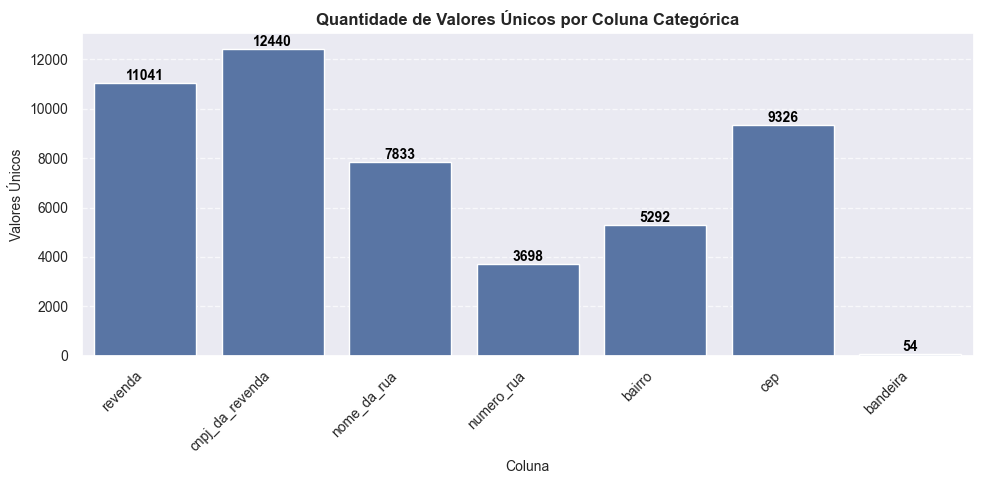

In [30]:
# Criar figura e eixo
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=variabilidade_categorica["Coluna"], y=variabilidade_categorica["Valores Únicos"])

# Adicionar rótulos acima das barras
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

# Ajustar rótulos e layout
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.title("Quantidade de Valores Únicos por Coluna Categórica", fontsize=12, fontweight='bold')
plt.ylabel("Valores Únicos", fontsize=10)
plt.xlabel("Coluna", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Exibir gráfico
plt.show()

### 1.7.3.1 Teste Estatístico ANOVA: Influência das Categorias no Preço

Para entender se algumas colunas influenciam os preços dos combustíveis, utilizamos o **Teste ANOVA**, que avalia se há **diferença estatisticamente significativa** entre grupos. 

Se o **p-valor for menor que 0.05**, significa que a categoria tem um impacto significativo nos preços.

In [31]:
# Função para calcular ANOVA
def calcular_anova(df, coluna):
    grupos = [grupo["valor_de_venda"].dropna().values for _, grupo in df.groupby(coluna)]
    if len(grupos) > 1:
        stat, p_value = stats.f_oneway(*grupos)
        return p_value
    else:
        return None  # Apenas um grupo, sem ANOVA

# Aplicando o teste ANOVA
anova_results = {col: calcular_anova(df2_combustiveis, col) for col in ['bandeira', 'bairro', 'revenda']}

# Criando um DataFrame com os resultados
anova_df = pd.DataFrame.from_dict(anova_results, orient='index', columns=['p-valor']).reset_index()
anova_df.rename(columns={'index': 'Coluna'}, inplace=True)

# Exibir tabela de ANOVA
anova_df

,Coluna,p-valor
0,bandeira,0.0000
1,bairro,0.0000
2,revenda,0.0000


### 1.7.3.2 Analisando a Variação de Preço por CEP e CNPJ

In [32]:
# Estatísticas de preços por CEP e CNPJ
estatisticas_cep = df2_combustiveis.groupby('cep')['valor_de_venda'].agg(['mean', 'std']).reset_index()
estatisticas_cnpj = df2_combustiveis.groupby('cnpj_da_revenda')['valor_de_venda'].agg(['mean', 'std']).reset_index()

# Exibir tabelas
display(estatisticas_cep.head(15))
display(estatisticas_cnpj.head(15))

,cep,mean,std
0,00000-000,5.4625,0.6047
1,01102-000,4.0100,0.7420
2,01105-000,5.2400,1.0648
3,01107-000,4.6836,0.8670
4,01124-040,4.1600,0.8634
5,01139-003,4.6498,0.9326
6,01139-040,6.2796,0.9021
7,01141-030,5.0876,0.9965
8,01142-200,4.6380,0.9744
9,01155-000,4.6481,0.9432


,cnpj_da_revenda,mean,std
0,00.001.974/0001-90,5.0139,0.9749
1,00.002.953/0001-99,5.0517,1.0486
2,00.002.953/0002-70,4.9171,1.0230
3,00.003.188/0001-21,4.1075,0.8748
4,00.003.188/0004-74,4.1180,0.8705
5,00.003.188/0005-55,4.2756,0.9095
6,00.003.188/0016-08,4.2638,0.8636
7,00.005.087/0001-90,5.4326,0.5563
8,00.005.892/0001-13,5.2612,0.7535
9,00.007.663/0001-38,4.9878,1.0267


### Decisão Final Sobre as Colunas

Com base nos resultados das análises:

✅ **`Bandeira` deve ser mantida**, pois a ANOVA mostrou que tem um impacto significativo nos preços.  
✅ **`Bairro` e `Revenda` apresentaram p-valor baixo na ANOVA, indicando que podem influenciar os preços.** Podemos reavaliar no futuro.  
❌ **`CNPJ da Revenda` e `CEP` serão removidos**, pois os preços dentro desses grupos variam pouco.  
❌ **`Nome da Rua` e `Número Rua` serão removidos**, pois têm muitos valores únicos e não agregam valor na previsão de preços.  

Agora que tomamos essas decisões, podemos seguir para a análise exploratória e futura modelagem!

In [33]:
# Agrupando os dados e calculando a média do preço para cada combinação de Estado, Município, Produto e Data
df3_combustiveis = df2_combustiveis.groupby(['data_da_coleta','regiao_sigla', 'estado_sigla', 'municipio', 'produto', 'bandeira'], as_index=False)['valor_de_venda'].mean()

Para reduzir a volatilidade dos preços entre diferentes postos, **agregamos os dados** calculando a **média dos preços** para cada combinação de:

- Região  
- Estado  
- Município  
- Produto  
- Data  

In [34]:
# Exibir as primeiras linhas dos dados agregados
df3_combustiveis.head()

,data_da_coleta,regiao_sigla,estado_sigla,municipio,produto,bandeira,valor_de_venda
0,2023-01-02,CO,GO,AGUAS LINDAS DE GOIAS,DIESEL,BRANCA,6.5900
1,2023-01-02,CO,GO,AGUAS LINDAS DE GOIAS,DIESEL,RAIZEN,6.5900
2,2023-01-02,CO,GO,AGUAS LINDAS DE GOIAS,DIESEL,VIBRA ENERGIA,6.6900
3,2023-01-02,CO,GO,AGUAS LINDAS DE GOIAS,ETANOL,BRANCA,4.6150
4,2023-01-02,CO,GO,AGUAS LINDAS DE GOIAS,ETANOL,IPIRANGA,4.4900


---

### Justificativa:

- Nosso objetivo é prever **tendências regionais dos preços dos combustíveis**, e não o preço exato de cada posto individualmente. Para isso, realizamos um **processo de agregação dos dados**, reduzindo a granularidade para uma análise mais estável e representativa.
- Os preços podem **variar entre postos** da mesma cidade, devido à concorrência e localização.  
- A média reduz **ruído e outliers**, tornando o modelo mais estável.  
- Nosso objetivo não é prever o preço exato de um posto, mas **identificar tendências de preços em cada região**.  

### **Transformação dos Dados**
Para minimizar ruídos e variações extremas entre diferentes postos, os dados foram agrupados por:

- ✅ **Data da Coleta** (`data_da_coleta`) → Para capturar a variação temporal dos preços.
- ✅ **Região** (`regiao_sigla`) → Para considerar diferenças macroeconômicas regionais.
- ✅ **Estado** (`estado_sigla`) → Para captar impactos de políticas estaduais e impostos.
- ✅ **Município** (`municipio`) → Para capturar tendências locais nos preços.
- ✅ **Produto** (`produto`) → Diferenciar combustíveis como Gasolina, Etanol e Diesel.
- ✅ **Bandeira** (`bandeira`) → Algumas marcas possuem políticas de preços distintas.

Para cada combinação dessas variáveis, calculamos a **média do preço de venda (`valor_de_venda`)**.

### **Justificativa da Agregação**
1. **Redução da Variabilidade**  
   - Os preços entre postos variam devido à concorrência e localização específica.
   - A agregação suaviza essas diferenças, **reduzindo ruídos e outliers**.
   
2. **Foco em Tendências Regionais**   
   - Ao invés de prever o preço exato de um posto específico, queremos **modelar padrões de preços por região e período**.

3. **Melhora na Estabilidade do Modelo**  
   - Reduzimos o impacto de **postos individuais** que podem ter práticas de precificação atípicas.
   
4. **Ajuste para Modelos de Regressão**  
   - Agregar os dados garante que o modelo capture padrões **macroeconômicos e estruturais** em vez de variações muito específicas.

### **Resumo Final**
- O dataset final representa a **média dos preços por Estado, Município, Produto, Data e Bandeira**.
- Essa abordagem garante um modelo **mais robusto e interpretável**, evitando variações individuais de postos.
- O modelo poderá **prever tendências de preços regionais** com maior confiabilidade.

---
# 2.0. EDA - Análise Temporal - Tendência de Preços dos Combustíveis

Esta seção analisa a **variação dos preços dos combustíveis ao longo do tempo**, identificando padrões sazonais e tendências de aumento e redução.

In [35]:
df4_eda_combustiveis = df3_combustiveis.copy()
df4_eda_combustiveis.head()

,data_da_coleta,regiao_sigla,estado_sigla,municipio,produto,bandeira,valor_de_venda
0,2023-01-02,CO,GO,AGUAS LINDAS DE GOIAS,DIESEL,BRANCA,6.5900
1,2023-01-02,CO,GO,AGUAS LINDAS DE GOIAS,DIESEL,RAIZEN,6.5900
2,2023-01-02,CO,GO,AGUAS LINDAS DE GOIAS,DIESEL,VIBRA ENERGIA,6.6900
3,2023-01-02,CO,GO,AGUAS LINDAS DE GOIAS,ETANOL,BRANCA,4.6150
4,2023-01-02,CO,GO,AGUAS LINDAS DE GOIAS,ETANOL,IPIRANGA,4.4900


## 2.1.0 Distribuição dos Preços dos Combustíveis

### **Objetivo:**  
Entender como os preços dos combustíveis (Gasolina, Diesel e Etanol) estão distribuídos no período analisado e identificar padrões de precificação.


### **O que analisamos:**
- Criamos um **gráfico de distribuição (histograma + KDE)** para visualizar a dispersão dos preços.
- Geramos uma **tabela de frequência** para entender quantos registros estão dentro de cada faixa de preços.
- A análise foi segmentada por **tipo de combustível** para facilitar a comparação.

In [36]:
df4_eda_combustiveis.describe(exclude=['datetime64[ns]', 'object'])

,valor_de_venda
count,491637.0000
mean,5.2088
std,0.9445
min,2.6400
25%,4.3900
50%,5.4900
75%,5.9400
max,8.1900


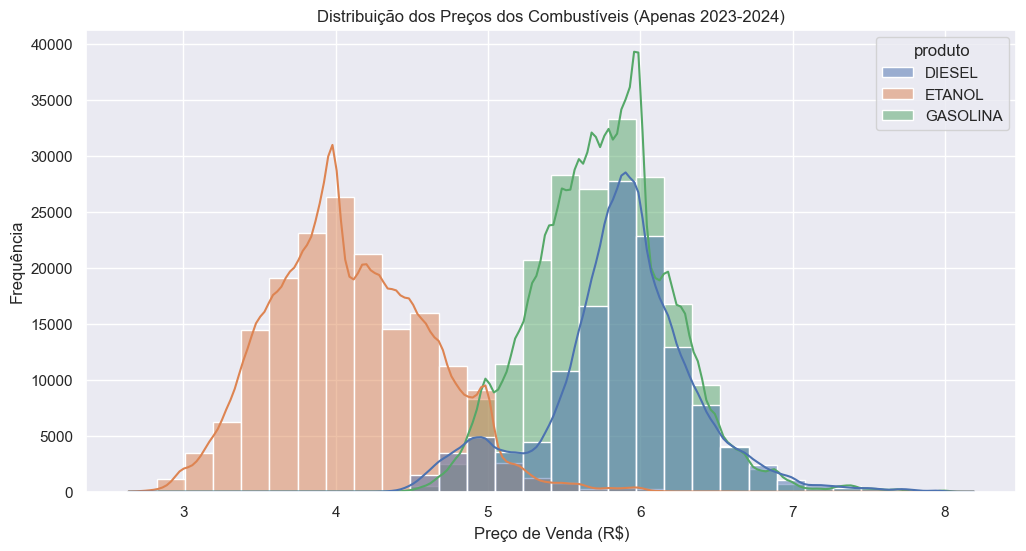

,Faixa de Preço (R$),Frequência (DIESEL),Frequência (ETANOL),Frequência (GASOLINA)
0,2.64 - 3.14,0,2951,0
1,3.14 - 3.64,0,30752,0
2,3.64 - 4.14,1,62358,1
3,4.14 - 4.64,1231,48051,368
4,4.64 - 5.14,10672,23295,15968
5,5.14 - 5.64,19334,3301,60112
6,5.64 - 6.14,63884,724,82608
7,6.14 - 6.64,24032,55,30046
8,6.64 - 7.14,5128,0,4356
9,7.14 - 7.64,1033,1,921


In [37]:
analisar_distribuicao_precos_por_produto(df4_eda_combustiveis)

### **Interpretação dos Resultados**
- **O Etanol apresenta preços significativamente mais baixos**, com concentração abaixo de **R$ 4,50**.
- **A Gasolina tem uma distribuição centrada entre R$ 5,14 e R$ 6,14**, sendo a faixa mais comum.
- **O Diesel exibe preços mais altos e maior dispersão**, sendo encontrado frequentemente acima de **R$ 6,00**.
- **Poucos registros acima de R$ 7,14** indicam que preços extremos são raros, podendo estar ligados a fatores logísticos ou regiões isoladas.

### **Conclusão:**  
- A análise confirma que **cada tipo de combustível possui um padrão distinto de precificação**, influenciado por fatores como **tributação, custo logístico e sazonalidade**.
- A maioria dos preços está dentro de uma faixa bem definida, mas existem variações que podem ser exploradas em análises futuras. 

## 2.2.0  - Tendência e Sazonalidade dos Preços dos Combustíveis (2023-2024)

### **Objetivo:**  
Analisar a evolução dos preços dos combustíveis (**Gasolina, Diesel e Etanol**) nos anos de **2023 e 2024**, identificando padrões de alta, queda e estabilidade, além de possíveis efeitos sazonais.


### **O que analisamos:**
- Calculamos a **média mensal** dos preços para cada tipo de combustível.
- Criamos um **gráfico de linha** para visualizar a evolução dos preços ao longo dos meses.
- Identificamos períodos de **queda, alta e estabilidade** e analisamos **padrões sazonais** dentro do ano.


In [38]:
# Garantir que a data esteja no formato correto
df4_eda_combustiveis['data_da_coleta'] = pd.to_datetime(df4_eda_combustiveis['data_da_coleta'])

# Calcular a média mensal dos preços para cada produto
df_tendencia = df4_eda_combustiveis.groupby(
    [df4_eda_combustiveis['data_da_coleta'].dt.to_period('M'), 'produto']
)['valor_de_venda'].mean().reset_index()

# Converter para datetime para gráfico
df_tendencia['data_da_coleta'] = df_tendencia['data_da_coleta'].astype(str) + '-01'
df_tendencia['data_da_coleta'] = pd.to_datetime(df_tendencia['data_da_coleta'])

# Visualizar os primeiros registros
df_tendencia.head(10)

,data_da_coleta,produto,valor_de_venda
0,2023-01-01,DIESEL,6.3528
1,2023-01-01,ETANOL,4.1305
2,2023-01-01,GASOLINA,5.0699
3,2023-02-01,DIESEL,6.0917
4,2023-02-01,ETANOL,4.0846
5,2023-02-01,GASOLINA,5.1335
6,2023-03-01,DIESEL,5.8889
7,2023-03-01,ETANOL,4.1882
8,2023-03-01,GASOLINA,5.5390
9,2023-04-01,DIESEL,5.7614


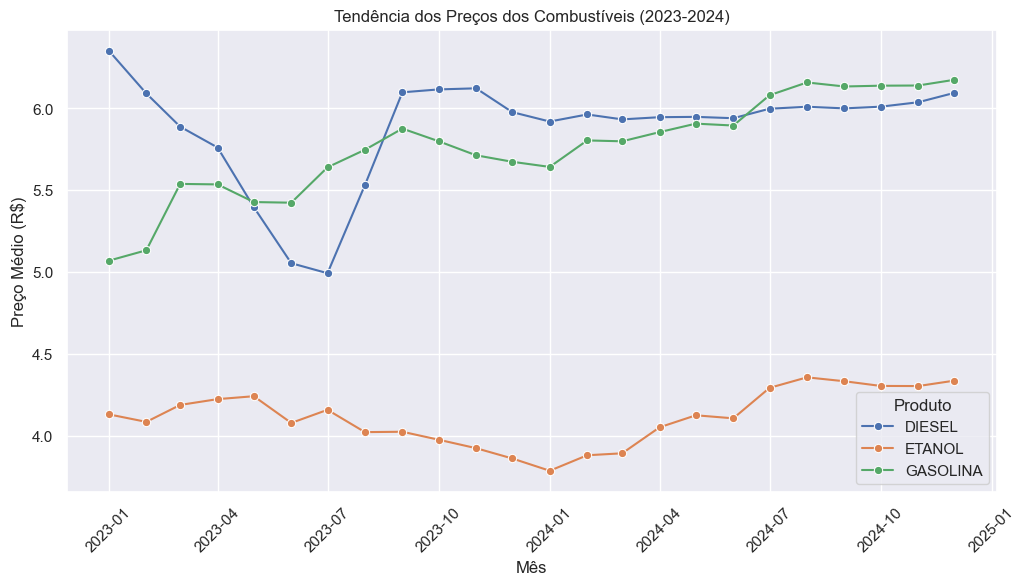

In [39]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_tendencia, x='data_da_coleta', y='valor_de_venda', hue='produto', marker="o")

plt.title("Tendência dos Preços dos Combustíveis (2023-2024)")
plt.xlabel("Mês")
plt.ylabel("Preço Médio (R$)")
plt.xticks(rotation=45)
plt.legend(title="Produto")
plt.show()


### **Interpretação dos Resultados**

#### **1️. Diesel**
- Forte queda no primeiro semestre de 2023 (R$ 6,35 → R$ 4,99 em julho), seguida de uma recuperação rápida até outubro e estabilização entre R$ 5,90 e R$ 6,10 em 2024. Exibe um padrão sazonal claro, com quedas no primeiro semestre e altas no segundo.

#### **2️. Gasolina**
- Tendência de alta moderada ao longo do tempo, com aceleração a partir de julho de 2023 e estabilização acima de R$ 5,50. Apresenta menor volatilidade e oscilações suaves sem um ciclo sazonal bem definido.

#### **3️. Etanol**
- Preço mais baixo e oscilações bruscas, impactadas pela safra e entressafra da cana-de-açúcar. Caiu para R$ 3,78 no início de 2024, mas recuperou-se gradualmente ao longo do ano, atingindo R$ 4,33 em dezembro. Exibe um padrão sazonal cíclico, com queda no meio do ano e recuperação no final.

### **Conclusão:** ***Os preços dos combustíveis seguem padrões distintos*** 
- Diesel tem forte sazonalidade.  
- Gasolina mantém uma tendência de alta estável. 
- Etanol oscila com a produção agrícola. 
- A recuperação dos preços em 2024 sugere um mercado mais previsível, mas sujeito a fatores externos como câmbio e custo do petróleo.


## 2.3.0 - Comparação de Tendência por Ano (2023 vs. 2024)

### **Objetivo:**  
Comparar a evolução dos preços dos combustíveis (**Gasolina, Diesel e Etanol**) nos anos de **2023 e 2024**, destacando mudanças no comportamento dos preços mês a mês.



### **O que analisamos:**
- Criamos gráficos separados para cada combustível, comparando os anos de **2023 e 2024**.
- Geramos uma **tabela com os valores médios por mês** para análise numérica detalhada.
- Avaliamos se os preços **seguiram um padrão semelhante ou mudaram de comportamento**.


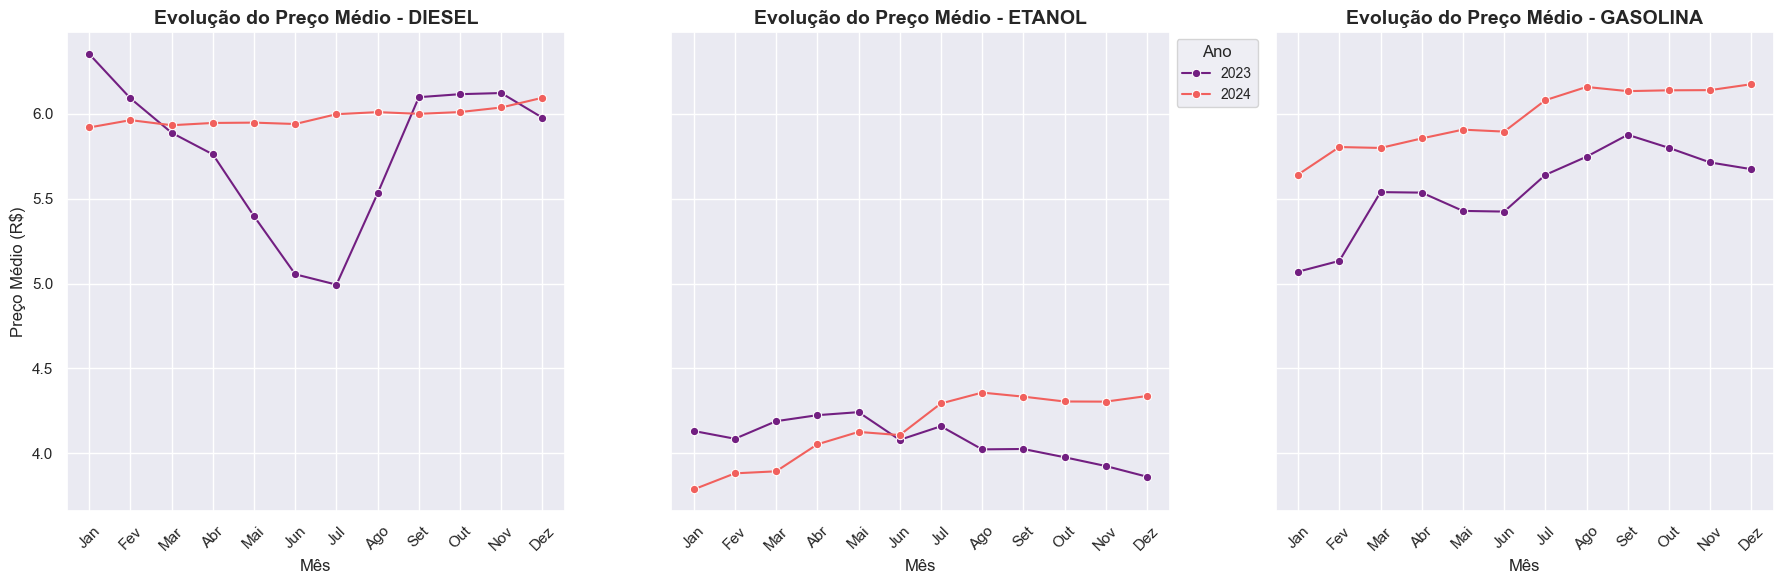

In [40]:
# Criar uma nova coluna com apenas o ano
df4_eda_combustiveis['ano'] = df4_eda_combustiveis['data_da_coleta'].dt.year
df4_eda_combustiveis['mes'] = df4_eda_combustiveis['data_da_coleta'].dt.month

# Calcular a média de preços por ano e mês para cada combustível
df_ano_tendencia = df4_eda_combustiveis.groupby(['ano', 'mes', 'produto'])['valor_de_venda'].mean().reset_index()

# Criar figura com subgráficos
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)  # sharey=True mantém o eixo Y padronizado

# Lista dos combustíveis
combustiveis = ["DIESEL", "ETANOL", "GASOLINA"]

# Paleta de cores para diferenciar os anos
cores = sns.color_palette("magma", n_colors=df_ano_tendencia["ano"].nunique())

# Criar um gráfico separado para cada combustível
for i, combustivel in enumerate(combustiveis):
    ax = axes[i]
    
    # Filtrar os dados
    df_filtro = df_ano_tendencia[df_ano_tendencia["produto"] == combustivel]
    
    # Criar o gráfico de linhas
    sns.lineplot(
        data=df_filtro,
        x="mes",
        y="valor_de_venda",
        hue="ano",
        marker="o",
        palette=cores,
        ax=ax
    )
    
    # Ajustar os rótulos do eixo X
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'], rotation=45)

    # Ajustar título e rótulos
    ax.set_title(f"Evolução do Preço Médio - {combustivel}", fontsize=14, fontweight="bold")
    ax.set_xlabel("Mês")
    ax.set_ylabel("Preço Médio (R$)")

    # Ajustar a legenda
    if i == 1:  # Somente no gráfico do meio
        ax.legend(title="Ano", fontsize=10, loc="upper left", bbox_to_anchor=(1, 1))
    else:
        ax.get_legend().remove()  # Remover a legenda dos outros gráficos para não repetir

# Ajustar espaçamento e exibir
plt.tight_layout()
plt.show()

In [41]:
# Calcular a média dos preços por mês e ano
df_comparacao = df4_eda_combustiveis.groupby(['mes', 'ano', 'produto'])['valor_de_venda'].mean().reset_index()

# Pivotar a tabela para ter colunas separadas por ano
df_comparacao_pivot = df_comparacao.pivot_table(index=['mes', 'produto'], columns='ano', values='valor_de_venda').reset_index()

# Renomear colunas para melhor visualização
df_comparacao_pivot.columns = ['Mês', 'Produto', 'Preço Médio 2023', 'Preço Médio 2024']

df_comparacao_pivot

,Mês,Produto,Preço Médio 2023,Preço Médio 2024
0,1,DIESEL,6.3528,5.9202
1,1,ETANOL,4.1305,3.7859
2,1,GASOLINA,5.0699,5.6428
3,2,DIESEL,6.0917,5.9634
4,2,ETANOL,4.0846,3.8806
5,2,GASOLINA,5.1335,5.8048
6,3,DIESEL,5.8889,5.9334
7,3,ETANOL,4.1882,3.8926
8,3,GASOLINA,5.5390,5.7994
9,4,DIESEL,5.7614,5.9468


### **Interpretação dos Resultados**
#### **1. Diesel**
- Em 2023, teve queda expressiva até julho (~R$ 6,35 → R$ 4,99), seguida de recuperação. 
- Em 2024, oscilou em torno de R$ 6,00 com menor volatilidade, indicando maior estabilidade no mercado.

#### **2️. Etanol**
- Em 2023, caiu ao longo do ano, fechando abaixo de R$ 3,80. 
- Em 2024, começou mais baixo, mas apresentou leve recuperação a partir de julho (~R$ 4,35), refletindo a safra da cana, preços da gasolina e políticas tributárias.

#### **3️. Gasolina**
- Em 2023, subiu gradualmente até atingir ~R$ 5,90 - R$ 6,00 em agosto. 
- Em 2024, já iniciou mais cara (~R$ 5,90) e seguiu um padrão de alta moderada, chegando a ~R$ 6,20 no final do ano, sugerindo influência de reajustes da Petrobras e tributos.


### **Conclusão Geral**
- Diesel ficou mais estável em 2024, reduzindo volatilidade.
- Etanol teve um comportamento inverso entre os anos, caindo em 2023 e subindo em 2024.
- Gasolina iniciou 2024 em um patamar mais alto, mantendo tendência de alta.
- A análise mensal reforça o impacto de fatores como safra, tributos e reajustes no mercado.

## 2.4.0 - Comparação Regional dos Preços

### **Objetivo:**  
Analisar como os preços médios dos combustíveis **variam entre diferentes regiões e estados**, destacando padrões e discrepâncias.  

### **O que analisamos:**  
- Criamos **boxplots separados por tipo de combustível** para visualizar a dispersão dos preços por **região**.  
- Geramos uma **tabela comparativa**, onde podemos observar os preços médios e a variação (**desvio padrão**) por **região e estado**.  


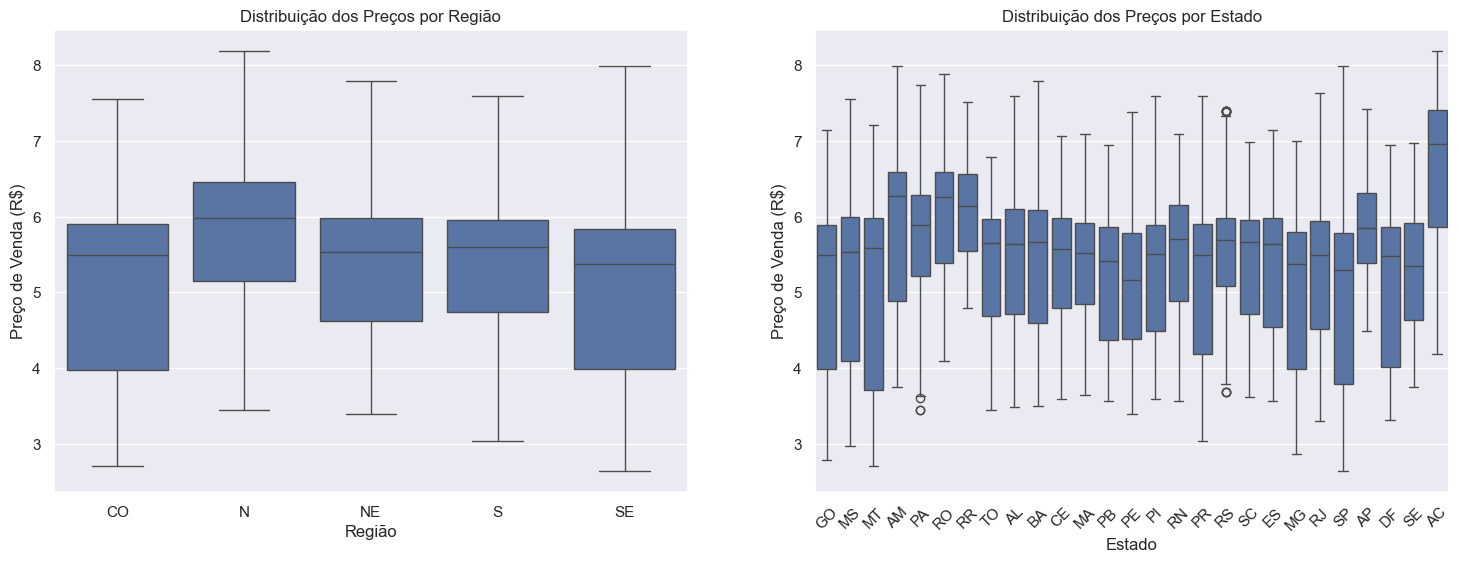

In [42]:
# Criando boxplots para visualizar distribuição dos preços por região e estado
plt.figure(figsize=(18, 6))

# Boxplot por região
plt.subplot(1, 2, 1)
sns.boxplot(data=df4_eda_combustiveis, x='regiao_sigla', y='valor_de_venda')
plt.title("Distribuição dos Preços por Região")
plt.xlabel("Região")
plt.ylabel("Preço de Venda (R$)")

# Boxplot por estado
plt.subplot(1, 2, 2)
sns.boxplot(data=df4_eda_combustiveis, x='estado_sigla', y='valor_de_venda')
plt.xticks(rotation=45)
plt.title("Distribuição dos Preços por Estado")
plt.xlabel("Estado")
plt.ylabel("Preço de Venda (R$)")

plt.show()

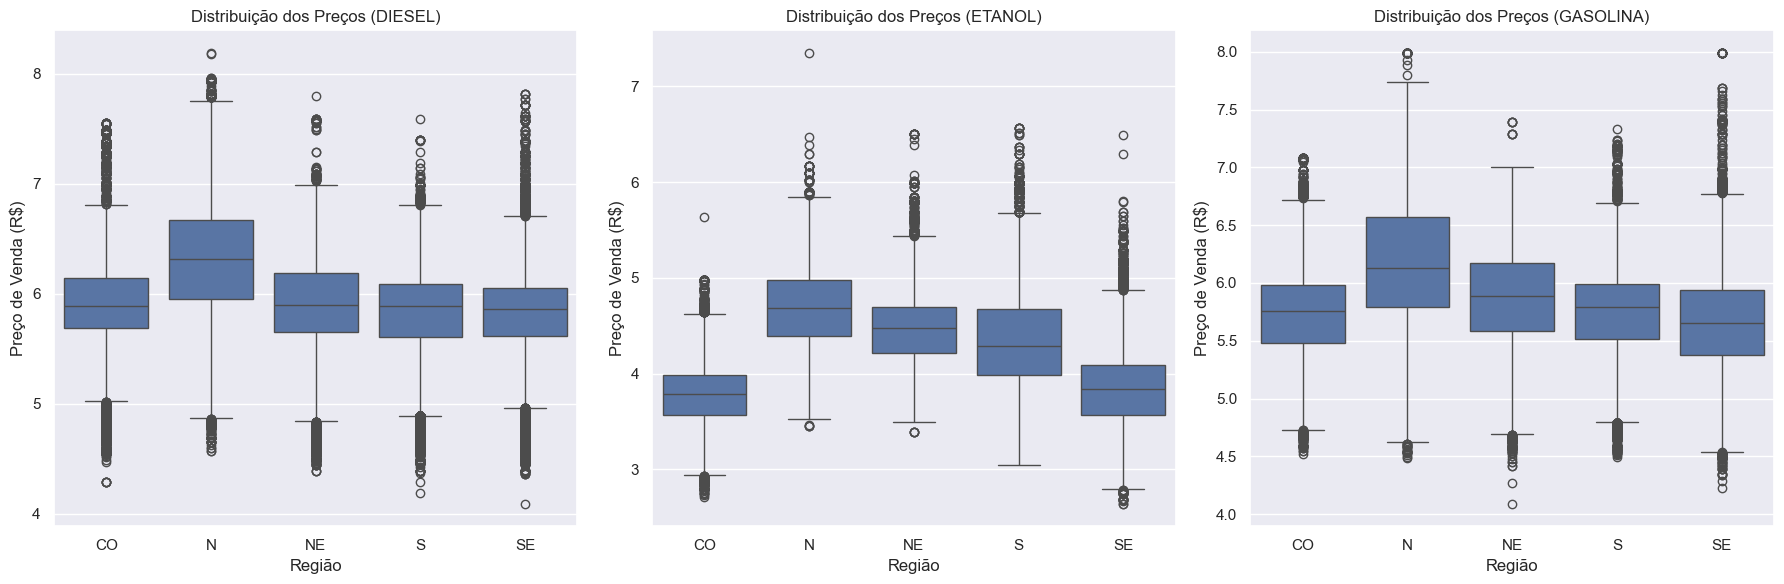

In [43]:
# Criar gráficos de boxplot para cada tipo de combustível
plt.figure(figsize=(18, 6))

combustiveis = df4_eda_combustiveis['produto'].unique()

for i, combustivel in enumerate(combustiveis):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(data=df4_eda_combustiveis[df4_eda_combustiveis['produto'] == combustivel], 
                x='regiao_sigla', y='valor_de_venda')
    plt.title(f"Distribuição dos Preços ({combustivel})")
    plt.xlabel("Região")
    plt.ylabel("Preço de Venda (R$)")

plt.tight_layout()
plt.show()


In [44]:
# Criar tabela de média e desvio por região
tabela_regiao = df4_eda_combustiveis.groupby(['regiao_sigla', 'produto'])['valor_de_venda'].agg(['mean', 'std']).reset_index()

# Pivotar para ter combustíveis como colunas (média e desvio padrão juntos)
tabela_regiao_pivot = tabela_regiao.pivot(index='regiao_sigla', columns='produto', values=['mean', 'std'])

# Renomear colunas
tabela_regiao_pivot.columns = [f'{combustivel} Média (R$)' if metrica == 'mean' else f'{combustivel} ± (R$)' 
                               for metrica, combustivel in tabela_regiao_pivot.columns]
tabela_regiao_pivot.reset_index(inplace=True)

# Criar a mesma estrutura para os estados
tabela_estado = df4_eda_combustiveis.groupby(['estado_sigla', 'produto'])['valor_de_venda'].agg(['mean', 'std']).reset_index()
tabela_estado_pivot = tabela_estado.pivot(index='estado_sigla', columns='produto', values=['mean', 'std'])
tabela_estado_pivot.columns = [f'{combustivel} Média (R$)' if metrica == 'mean' else f'{combustivel} ± (R$)' 
                               for metrica, combustivel in tabela_estado_pivot.columns]
tabela_estado_pivot.reset_index(inplace=True)

# Exibir tabelas com média e desvio juntos
display(tabela_regiao_pivot)
display(tabela_estado_pivot)

,regiao_sigla,DIESEL Média (R$),ETANOL Média (R$),GASOLINA Média (R$),DIESEL ± (R$),ETANOL ± (R$),GASOLINA ± (R$)
0,CO,5.8864,3.7967,5.7341,0.5017,0.3579,0.4133
1,N,6.3068,4.6944,6.1703,0.6084,0.4296,0.5976
2,NE,5.8785,4.4769,5.8624,0.4845,0.3711,0.4348
3,S,5.8038,4.3378,5.7670,0.4295,0.4951,0.3781
4,SE,5.8077,3.8563,5.6459,0.4488,0.4161,0.4047


,estado_sigla,DIESEL Média (R$),ETANOL Média (R$),GASOLINA Média (R$),DIESEL ± (R$),ETANOL ± (R$),GASOLINA ± (R$)
0,AC,7.2163,5.0325,6.9572,0.5045,0.4407,0.5775
1,AL,6.1676,4.5652,5.9897,0.6049,0.4665,0.4495
2,AM,6.3230,4.5507,6.5436,0.5654,0.3290,0.6328
3,AP,6.2359,5.1531,5.5978,0.5134,0.2454,0.3716
4,BA,5.8729,4.4339,6.0169,0.4805,0.2932,0.3734
5,CE,6.0125,4.7417,5.9639,0.4651,0.3123,0.3441
6,DF,5.7992,3.8734,5.6480,0.4091,0.2349,0.3416
7,ES,5.7636,4.3245,5.8757,0.3954,0.2913,0.4355
8,GO,5.7740,3.8335,5.7031,0.4301,0.3122,0.3742
9,MA,5.7847,4.6118,5.6933,0.4329,0.3258,0.4610


**O desvio padrão indica o nível de variação dos preços dentro de cada região.** 

### **Interpretação dos Resultados**  

#### **1. Diferenças Regionais**
- Região Norte tem os preços médios mais altos para todos os combustíveis, com maior variação.
- Centro-Oeste apresenta os menores preços para o Etanol, enquanto Diesel e Gasolina têm maior oscilação.
- Sudeste tem preços mais homogêneos, especialmente para Diesel e Gasolina.

**Fatores que explicam:**  
- Custos logísticos e distribuição impactam diretamente os preços nas regiões.
- Estados produtores de Etanol (SP e GO) possuem preços menores devido à maior oferta.
- Políticas de ICMS estaduais influenciam o valor final ao consumidor.


#### **2️. Diferenças Estaduais**
- Acre, Amazonas e Rondônia possuem os preços mais altos, refletindo desafios logísticos.
- São Paulo e Goiás têm os menores preços para Etanol e Gasolina, impulsionados pela produção local.
- Roraima e Amapá apresentam baixa variação nos preços, sugerindo menor concorrência.

### **Conclusão**
- Regiões Norte e Nordeste enfrentam preços mais altos e voláteis.
- Centro-Oeste e Sudeste possuem valores mais baixos, especialmente no Etanol.
- Fatores logísticos, produção interna e tributação estadual são determinantes na precificação.

---
# 3.0. Análise de Correlação com Variáveis Macroeconômicas

Nesta seção, investigamos **como os preços dos combustíveis são influenciados** por fatores macroeconômicos, como:
- **Taxa de câmbio (USD/BRL)** → Impacto no custo da importação de petróleo e derivados.
- **Inflação (IPCA)** → Possível efeito sobre o custo de vida e consumo.
- **Preço do petróleo (Brent e WTI)** → Base de precificação dos combustíveis no mercado internacional.
- **Taxa SELIC** → Influência indireta nos investimentos e no custo de crédito para o setor.

O objetivo desta análise é:

✅ **Identificar correlações significativas** entre os preços dos combustíveis e variáveis macroeconômicas.  
✅ **Avaliar a força e o sentido dessas relações**, ajudando na construção de modelos preditivos.  
✅ **Analisar se o impacto dessas variáveis ocorre de forma imediata ou com defasagem temporal.**  
✅ **Quantificar os efeitos dessas variáveis no preço dos combustíveis.** 

---

## Tratamento inicial para Dados Macroeconômicos `df_macro`

Os dados macroeconômicos precisam ser preparados antes do merge com os preços dos combustíveis.  
As seguintes etapas são realizadas:
- **Padronização dos nomes das colunas** para facilitar a manipulação dos dados.
- **Conversão da coluna de data** para o formato `datetime`, garantindo compatibilidade na mesclagem.
- **Filtragem para manter apenas os dados a partir de 2023**, pois queremos analisar o impacto recente dessas variáveis.
- **Análise de colunas vazias e qualidade dos dados** para verificar se há problemas estruturais.
- **Verificação e remoção de duplicatas**, evitando distorções no merge.
- **Consolidação dos dados macroeconômicos** para garantir **uma única entrada por dia**, prevenindo duplicações indesejadas.

In [45]:
# 1. Renomeando colunas para um formato padronizado
colunas_antigas = df_macro.columns.to_list()
colunas_novas = [renomear_coluna(col) for col in colunas_antigas]
df_macro = df_macro.rename(columns=dict(zip(colunas_antigas, colunas_novas)))

In [46]:
# 2. Convertendo a coluna de data para datetime
df_macro['date'] = pd.to_datetime(df_macro['date'])

In [47]:
# 3. Filtrando os dados macroeconômicos a partir de 2023
df_macro = df_macro[df_macro['date'].dt.year >= 2023]

In [48]:
# 4. Analisando colunas vazias e qualidade dos dados antes do merge
display(analisar_colunas_vazias(df_macro))
display(analisar_qualidade_dados(df_macro))

,Coluna,Valores Nulos,Porcentagem de Nulos (%),100% Vazia,Possui Nulos,Valor Único (Possível Constante)
0,date,0,0.0000,False,False,False
1,taxa_usd,0,0.0000,False,False,False
2,ipca,0,0.0000,False,False,False
3,brent_price,0,0.0000,False,False,False
4,wti_price,0,0.0000,False,False,False
5,selic,0,0.0000,False,False,False


Linhas Duplicadas no DataFrame: 17


,Coluna,"Valores Vazios ("""")","Espaços em Branco ("" "")",Valores Únicos
0,date,0,0,771
1,taxa_usd,0,0,632
2,ipca,0,0,21
3,brent_price,0,0,447
4,wti_price,0,0,439
5,selic,0,0,8


In [49]:
# 5. Verificando a existência de valores duplicados
df_duplicadas = df_macro[df_macro.duplicated(keep=False)]
if not df_duplicadas.empty:
    display(df_duplicadas.shape)  # Mostra quantas duplicatas existem antes da limpeza

(34, 6)

In [50]:
# 6. Removendo duplicatas e consolidando as informações por data
df_macro = df_macro.drop_duplicates()  # Remove entradas idênticas
df_macro = df_macro.groupby('date', as_index=False).mean()  # Garante uma única entrada por dia

In [51]:
# 7. Verificando o resultado final do tratamento
display(df_macro.head())
display(df_macro.dtypes)

,date,taxa_usd,ipca,brent_price,wti_price,selic
0,2023-01-01,5.2860,0.5300,85.9100,80.2600,13.7500
1,2023-01-02,5.3633,0.5300,85.9100,80.2600,13.7500
2,2023-01-03,5.4797,0.5300,82.1000,76.9300,13.7500
3,2023-01-04,5.4312,0.5300,77.8400,72.8400,13.7500
4,2023-01-05,5.3509,0.5300,78.6900,73.6700,13.7500


date           datetime64[ns]
taxa_usd              float64
ipca                  float64
brent_price           float64
wti_price             float64
selic                 float64
dtype: object

## Mesclagem dos Dados Macroeconômicos com os Dados de Combustíveis
Agora, unimos os dados macroeconômicos ao conjunto de dados de combustíveis, garantindo que cada linha mantenha sua integridade original.


In [52]:
# Realizando o merge
df_final_00 = df4_eda_combustiveis.merge(df_macro, left_on='data_da_coleta', right_on='date', how='left')

# Removendo a coluna redundante 'date'
df_final_00.drop(columns=['date'], inplace=True)

# Visualizando os primeiros registros após o merge
display(df_final_00.head())

# Analisando colunas vazias e qualidade dos dados pós-merge
analisar_colunas_vazias(df_final_00)
analisar_qualidade_dados(df_final_00)

# Verificando duplicatas após a mesclagem
df_duplicadas = df_final_00[df_final_00.duplicated(keep=False)]
display(df_duplicadas.head())

# Comparando o tamanho dos DataFrames antes e depois do merge
print(f"Tamanho original do df4_eda_combustiveis: {df4_eda_combustiveis.shape}")
print(f"Tamanho após o merge: {df_final_00.shape}")

,data_da_coleta,regiao_sigla,estado_sigla,municipio,produto,bandeira,valor_de_venda,ano,mes,taxa_usd,ipca,brent_price,wti_price,selic
0,2023-01-02,CO,GO,AGUAS LINDAS DE GOIAS,DIESEL,BRANCA,6.5900,2023,1,5.3633,0.5300,85.9100,80.2600,13.7500
1,2023-01-02,CO,GO,AGUAS LINDAS DE GOIAS,DIESEL,RAIZEN,6.5900,2023,1,5.3633,0.5300,85.9100,80.2600,13.7500
2,2023-01-02,CO,GO,AGUAS LINDAS DE GOIAS,DIESEL,VIBRA ENERGIA,6.6900,2023,1,5.3633,0.5300,85.9100,80.2600,13.7500
3,2023-01-02,CO,GO,AGUAS LINDAS DE GOIAS,ETANOL,BRANCA,4.6150,2023,1,5.3633,0.5300,85.9100,80.2600,13.7500
4,2023-01-02,CO,GO,AGUAS LINDAS DE GOIAS,ETANOL,IPIRANGA,4.4900,2023,1,5.3633,0.5300,85.9100,80.2600,13.7500


Linhas Duplicadas no DataFrame: 0


,data_da_coleta,regiao_sigla,estado_sigla,municipio,produto,bandeira,valor_de_venda,ano,mes,taxa_usd,ipca,brent_price,wti_price,selic


Tamanho original do df4_eda_combustiveis: (491637, 9)
Tamanho após o merge: (491637, 14)


---
## 3.1 Matriz de Correlação e Defasagem (Lag Analysis)

### **3.1.1 Matriz de Correlação**

A matriz de correlação mede o **grau de associação linear** entre as variáveis.  
Os valores variam de **-1 a 1**:
- **1.00** → Correlação positiva perfeita (as variáveis sobem ou descem juntas).
- **0.00** → Sem correlação (não há relação linear entre as variáveis).
- **-1.00** → Correlação negativa perfeita (quando uma variável sobe, a outra desce).

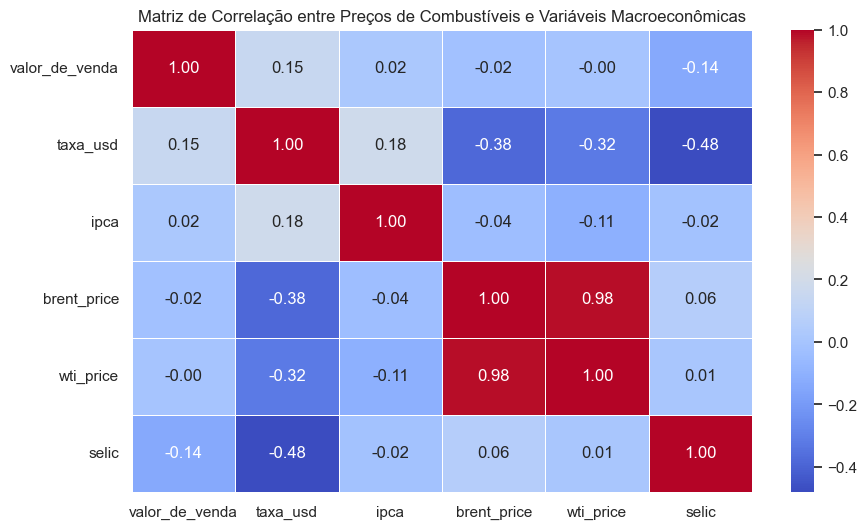

In [53]:
# Selecionando apenas as colunas relevantes para a correlação
cols_corr = ['valor_de_venda', 'taxa_usd', 'ipca', 'brent_price', 'wti_price', 'selic']

# Calculando a matriz de correlação
corr_matrix = df_final_00[cols_corr].corr()

# Criando o heatmap da correlação
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlação entre Preços de Combustíveis e Variáveis Macroeconômicas")
plt.show()

In [54]:
# Criando a matriz de correlação em formato de tabela
df_correlation = df_final_00[cols_corr].corr()

# Exibindo a matriz de correlação no notebook
display(df_correlation)

,valor_de_venda,taxa_usd,ipca,brent_price,wti_price,selic
valor_de_venda,1.0000,0.1488,0.0210,-0.0188,-0.0020,-0.1352
taxa_usd,0.1488,1.0000,0.1847,-0.3843,-0.3209,-0.4800
ipca,0.0210,0.1847,1.0000,-0.0352,-0.1095,-0.0173
brent_price,-0.0188,-0.3843,-0.0352,1.0000,0.9842,0.0589
wti_price,-0.0020,-0.3209,-0.1095,0.9842,1.0000,0.0087
selic,-0.1352,-0.4800,-0.0173,0.0589,0.0087,1.0000


### **3.1.2 Análise de Defasagem (Lag Analysis)**

Os preços dos combustíveis podem **não reagir imediatamente** às mudanças macroeconômicas.  
Por exemplo, uma alta no **Brent** pode demorar algumas semanas para impactar os preços nas bombas.  

Isso pode ocorrer por diversos motivos, como:
- **Política de Preços da Petrobras** → Os ajustes nos combustíveis não seguem a cotação do Brent diariamente.
- **Contratos de Fornecimento** → Empresas podem comprar petróleo a preços fixos por períodos, reduzindo a volatilidade imediata.
- **Estoque de Combustíveis** → Variações nos preços do petróleo podem demorar para refletir no preço final devido ao tempo de refino e distribuição.

Para verificar essa relação **ao longo do tempo**, realizamos uma análise de **defasagem temporal (lag analysis)**, deslocando as variáveis macroeconômicas e observando suas correlações com os preços futuros dos combustíveis.


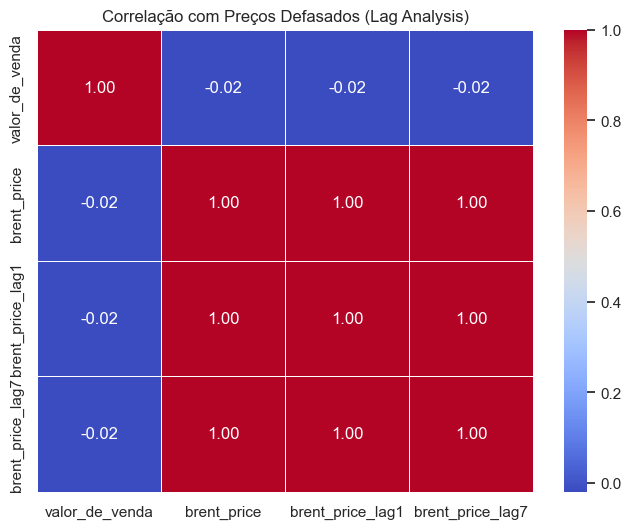

,valor_de_venda,brent_price,brent_price_lag1,brent_price_lag7
valor_de_venda,1.0000,-0.0188,-0.0188,-0.0188
brent_price,-0.0188,1.0000,1.0000,0.9997
brent_price_lag1,-0.0188,1.0000,1.0000,0.9998
brent_price_lag7,-0.0188,0.9997,0.9998,1.0000


,Variável,Correlação com Preço
0,Brent (Imediato),-0.0188
1,Brent (Lag 1 dia),-0.0188
2,Brent (Lag 7 dias),-0.0188


In [55]:
# Criando variáveis defasadas (lags) para análise de impacto retardado
df_final_00['brent_price_lag1'] = df_final_00['brent_price'].shift(1)  # Defasagem de 1 dia
df_final_00['brent_price_lag7'] = df_final_00['brent_price'].shift(7)  # Defasagem de 7 dias

# Matriz de correlação com variáveis defasadas
cols_corr_lag = ['valor_de_venda', 'brent_price', 'brent_price_lag1', 'brent_price_lag7']
corr_matrix_lag = df_final_00[cols_corr_lag].corr()

# Criando heatmap para correlações defasadas
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix_lag, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlação com Preços Defasados (Lag Analysis)")
plt.show()

# Criando a matriz de correlação com defasagens
df_correlation_lag = df_final_00[cols_corr_lag].corr()

# Exibindo a matriz de correlação defasada no notebook
display(df_correlation_lag)

# Criando um dataframe comparativo
df_lag_comparacao = pd.DataFrame({
    'Variável': ['Brent (Imediato)', 'Brent (Lag 1 dia)', 'Brent (Lag 7 dias)'],
    'Correlação com Preço': [
        df_correlation.loc['valor_de_venda', 'brent_price'],
        df_correlation_lag.loc['valor_de_venda', 'brent_price_lag1'],
        df_correlation_lag.loc['valor_de_venda', 'brent_price_lag7']
    ]
})

# Exibindo a tabela de comparação
display(df_lag_comparacao)

###  Conclusão Matriz de Correlação e Defasagem (Lag Analysis)

**Correlação entre Brent e Preço dos Combustíveis:**
 
- Correlação extremamente baixa (-0.0188), tanto imediata quanto defasada (1 e 7 dias).
- Mesmo testando diferentes atrasos, o Brent não afeta diretamente os preços no curto prazo. 

**Fatores que influenciam mais:**  
- Taxa de câmbio (USD/BRL) tem impacto moderado (~0.15), sugerindo que a variação cambial influencia os preços.
- IPCA e SELIC têm efeito indireto, impactando custos e demanda no longo prazo.  

**Conclusão:**
Os preços dos combustíveis não seguem diretamente as oscilações do Brent, pois fatores internos predominam:
- Política de preços da Petrobras, que evita repasses automáticos.
- Tributação e regulações, que podem amortecer variações do petróleo.
- Produção nacional de petróleo, reduzindo a dependência do mercado externo.

## 3.2 Gráficos de Dispersão e Quantificação da Relação (Regressão Linear)

Nesta seção, analisamos visualmente e quantitativamente **como os preços dos combustíveis variam em relação às variáveis macroeconômicas**.

**Objetivos:**
- **Visualizar a relação** entre as variáveis usando gráficos de dispersão.
- **Identificar tendências e padrões** (exemplo: o preço do combustível sobe quando o Brent sobe?).
- **Quantificar a influência** de cada variável sobre o preço do combustível através da regressão linear.


### **3.2.1 Gráficos de Dispersão**

Os gráficos de dispersão são úteis para observar **se há uma relação visual clara** entre os preços dos combustíveis e as variáveis macroeconômicas.

Caso exista uma tendência nos pontos (exemplo: uma linha ascendente), isso pode indicar **uma correlação positiva** entre as variáveis.  

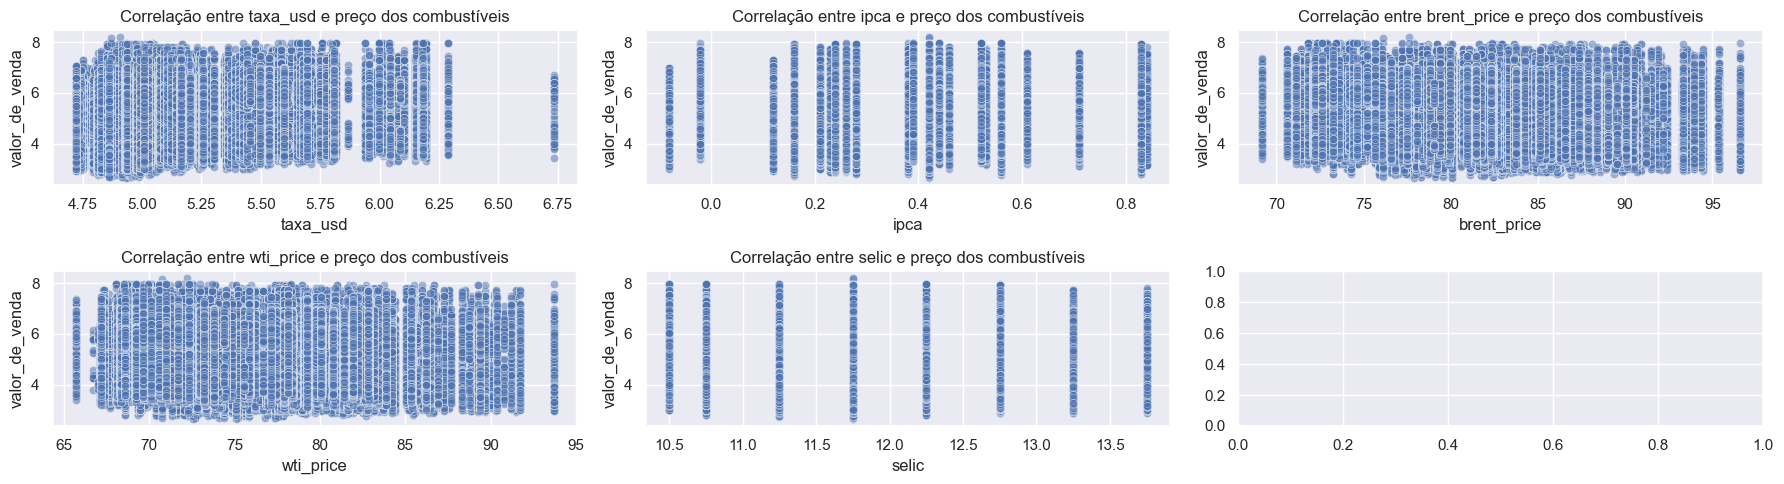

In [56]:
# Criando gráficos de dispersão para analisar relações visuais
fig, axes = plt.subplots(2, 3, figsize=(18, 5))

variaveis_macro = ['taxa_usd', 'ipca', 'brent_price', 'wti_price', 'selic']
for i, var in enumerate(variaveis_macro):
    ax = axes[i // 3, i % 3]
    sns.scatterplot(data=df_final_00, x=var, y='valor_de_venda', ax=ax, alpha=0.5)
    ax.set_title(f"Correlação entre {var} e preço dos combustíveis")

plt.tight_layout()
plt.show()

### **3.2.2 Estatísticas de Regressão Linear** 

A regressão linear simples permite quantificar o impacto de cada variável macroeconômica nos preços dos combustíveis.

Interpretação dos coeficientes:

- Se o coeficiente for positivo, significa que quando a variável macroeconômica sobe, o preço dos combustíveis tende a subir.
- Se for negativo, significa que o impacto é inverso (exemplo: quando a SELIC sobe, os preços dos combustíveis podem cair).
- Quanto maior o valor absoluto do coeficiente, mais forte é a influência dessa variável.

In [57]:
# Criando uma tabela com estatísticas descritivas
df_descriptive = df_final_00[['valor_de_venda', 'taxa_usd', 'ipca', 'brent_price', 'wti_price', 'selic']].describe()

# Exibindo no notebook
display(df_descriptive)

,valor_de_venda,taxa_usd,ipca,brent_price,wti_price,selic
count,491637.0000,491637.0000,491637.0000,491637.0000,491637.0000,491637.0000
mean,5.2088,5.1675,0.3782,81.2309,76.8897,12.1368
std,0.9445,0.3292,0.2279,5.5466,5.6744,1.2996
min,2.6400,4.7239,-0.0800,69.1900,65.7500,10.5000
25%,4.3900,4.9335,0.2300,76.7100,72.1900,10.7500
50%,5.4900,5.0486,0.3800,81.9200,77.1000,12.2500
75%,5.9400,5.3668,0.5300,85.1800,80.8300,13.7500
max,8.1900,6.7324,0.8400,96.5500,93.6800,13.7500


In [58]:
# Criando um dicionário para armazenar os coeficientes
coef_dict = {}

# Rodando uma regressão linear para cada variável macroeconômica
for var in ['taxa_usd', 'ipca', 'brent_price', 'wti_price', 'selic']:
    X = sm.add_constant(df_final_00[var])  # Adicionando constante para o modelo
    y = df_final_00['valor_de_venda']
    
    model = sm.OLS(y, X).fit()
    coef_dict[var] = model.params[1]  # Pegando apenas o coeficiente da variável explicativa

# Criando uma tabela com os coeficientes
df_regression = pd.DataFrame.from_dict(coef_dict, orient='index', columns=['Coeficiente'])
df_regression.index.name = 'Variável Macroeconômica'

# Exibindo no notebook
display(df_regression)

,Coeficiente
Variável Macroeconômica,
taxa_usd,0.4271
ipca,0.0869
brent_price,-0.0032
wti_price,-0.0003
selic,-0.0983


### Conclusão Gráficos de Dispersão e Quantificação da Relação (Regressão Linear) 

Os gráficos de dispersão mostram tendências, mas a **regressão linear confirma que a taxa de câmbio (USD/BRL) tem o maior impacto nos preços dos combustíveis**. 

---
# 4.0 Seleção de Variáveis para Modelagem Preditiva

Antes de construir nosso modelo preditivo, precisamos avaliar quais variáveis **realmente contribuem para a previsão dos preços dos combustíveis**.

#### Objetivo
- Verificar se variáveis como `brent_price_lag1` e `brent_price_lag7` têm impacto na previsão.
- Testar a **correlação** dessas variáveis com `valor_de_venda`.
- Rodar uma **Regressão Linear Inicial** com e sem os lags para comparar o desempenho.


## **4.1 Verificando a Correlação das Variáveis**

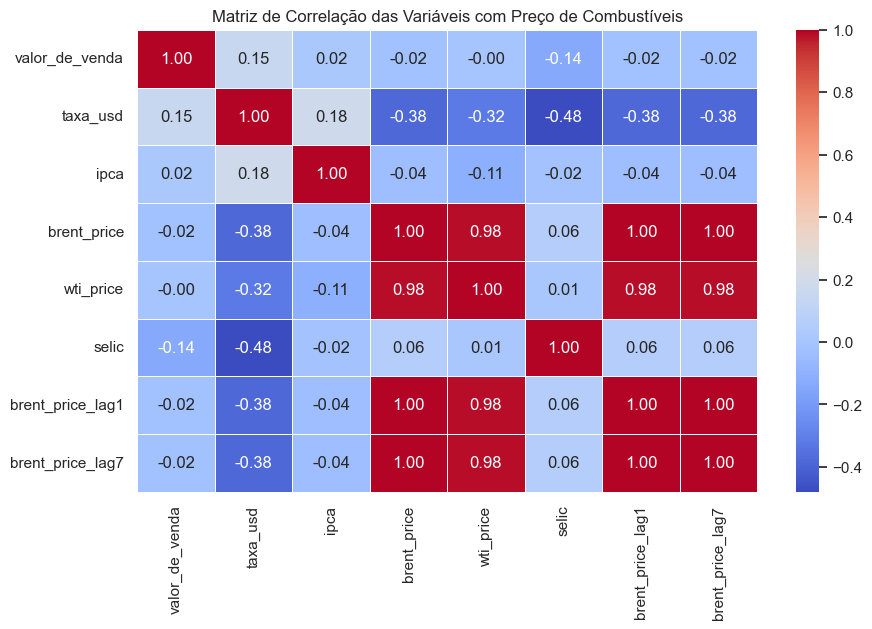

In [59]:
# Selecionando apenas as colunas relevantes para a correlação
cols_corr = ['valor_de_venda', 'taxa_usd', 'ipca', 'brent_price', 'wti_price', 'selic', 'brent_price_lag1', 'brent_price_lag7']

# Criando a matriz de correlação
corr_matrix = df_final_00[cols_corr].corr()

# Criando um heatmap para visualizar a correlação
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlação das Variáveis com Preço de Combustíveis")
plt.show()

Após analisar a **correlação das variáveis** e comparar modelos **com e sem os lags de `brent_price`**, chegamos às seguintes conclusões:

####  1. Conclusão Matriz de Correlação
- `brent_price_lag1` e `brent_price_lag7` **têm correlação muito baixa (-0.02) com `valor_de_venda`**, o que indica que **não influenciam diretamente os preços dos combustíveis**.  
- Essas variáveis possuem **correlação extremamente alta (1.00) com `brent_price`**, o que significa que elas **não adicionam informação nova ao modelo** e podem gerar colinearidade.

## **4.2 Teste de Importância das Variáveis (Feature Selection)**

Para garantir que as variáveis `brent_price_lag1` e `brent_price_lag7` são úteis, rodamos um teste comparativo de regressão:

- 1️. Modelo 1 (Sem Lags): Treinado com taxa_usd, ipca, brent_price, wti_price, selic.
- 2️. Modelo 2 (Com Lags): Mesmo modelo, mas adicionando brent_price_lag1 e brent_price_lag7.
- 3️. Comparação dos resultados para decidir se os lags devem ser incluídos.

In [60]:
# Definindo as variáveis para cada teste
features_basico = ['taxa_usd', 'ipca', 'brent_price', 'wti_price', 'selic']
features_com_lag = ['taxa_usd', 'ipca', 'brent_price', 'wti_price', 'selic', 'brent_price_lag1', 'brent_price_lag7']

In [61]:
# Rodando os dois modelos
result_basico = avaliar_modelo(features_basico, 'Regressão Linear (Sem Lags)')
result_com_lag = avaliar_modelo(features_com_lag, 'Regressão Linear (Com Lags)')

# Criando DataFrame de comparação
df_comparacao = pd.DataFrame([result_basico, result_com_lag])

# Exibir a tabela comparativa
display(df_comparacao)

,Modelo,R² Treino,R² Teste,RMSE Treino,RMSE Teste,MAE Treino,MAE Teste
0,Regressão Linear (Sem Lags),0.0138,-0.0357,0.9299,0.9451,0.7886,0.8639
1,Regressão Linear (Com Lags),0.0138,-0.0357,0.9299,0.9451,0.7886,0.8639


#### 2. Conclusão Feature Selection
- **Os modelos apresentaram exatamente os mesmos resultados**, mostrando que os lags **não contribuem para melhorar a previsão**.  
- **O R² de teste negativo (-0.0357)** indica que a Regressão Linear **não está conseguindo capturar bem a relação entre as variáveis macroeconômicas e os preços dos combustíveis**.  
- **Os erros (RMSE e MAE) permaneceram iguais**, confirmando que os lags **não adicionam valor preditivo**.


#### **Decisão Final**
✅ **Removemos `brent_price_lag1` e `brent_price_lag7` da modelagem preditiva.**  
✅ **Seguiremos apenas com as variáveis macroeconômicas (`taxa_usd`, `ipca`, `brent_price`, `wti_price`, `selic`).**  

---
# 5.0 Preparação dos Dados


In [62]:
df_model = df_final_00.copy()
display(df_model.head(3))

,data_da_coleta,regiao_sigla,estado_sigla,municipio,produto,bandeira,valor_de_venda,ano,mes,taxa_usd,ipca,brent_price,wti_price,selic,brent_price_lag1,brent_price_lag7
0,2023-01-02,CO,GO,AGUAS LINDAS DE GOIAS,DIESEL,BRANCA,6.5900,2023,1,5.3633,0.5300,85.9100,80.2600,13.7500,NaN,NaN
1,2023-01-02,CO,GO,AGUAS LINDAS DE GOIAS,DIESEL,RAIZEN,6.5900,2023,1,5.3633,0.5300,85.9100,80.2600,13.7500,85.9100,NaN
2,2023-01-02,CO,GO,AGUAS LINDAS DE GOIAS,DIESEL,VIBRA ENERGIA,6.6900,2023,1,5.3633,0.5300,85.9100,80.2600,13.7500,85.9100,NaN


# 6.0 Escalonamento (Rescaling)

In [63]:
rs = RobustScaler()
mms = MinMaxScaler()

In [64]:
# Criar dicionários para armazenar scalers e encoders
scalers = {
    "taxa_usd": RobustScaler(),
    "brent_price": RobustScaler(),
    "wti_price": RobustScaler(),
    "ipca": MinMaxScaler(),
    "selic": MinMaxScaler()
}

# Aplicar e salvar os scalers
for col, scaler in scalers.items():
    df_model[col] = scaler.fit_transform(df_model[[col]])  # Transformando os dados

# Salvar TODOS os scalers em um único arquivo
pickle.dump(scalers, open("../data/models/parameter/scalers.pkl", "wb"))

# 7.0 Codificação de Variáveis Categóricas (Encoding)

In [65]:
# Criar e salvar os LabelEncoders em um único dicionário
encoders = {col: LabelEncoder() for col in ['regiao_sigla', 'estado_sigla', 'municipio', 'produto', 'bandeira']}
for col, le in encoders.items():
    df_model[col] = le.fit_transform(df_model[col])  # Transformando os dados

# Salvar TODOS os encoders em um único arquivo
pickle.dump(encoders, open("../data/models/parameter/encoders.pkl", "wb"))

In [66]:
print("✅ Scalers e Encoders salvos corretamente!")

✅ Scalers e Encoders salvos corretamente!


# 8.0 - Transformação da Variável Alvo

In [67]:
df_model['valor_de_venda'] = np.log1p(df_model['valor_de_venda'])

# 🔹 5.4 - Transformações Cíclicas para Variáveis Temporais
df_model['mes_sin'] = np.sin(df_model['mes'] * (2. * np.pi / 12))
df_model['mes_cos'] = np.cos(df_model['mes'] * (2. * np.pi / 12))

df_model['dia_da_semana_sin'] = np.sin(df_model['data_da_coleta'].dt.dayofweek * (2. * np.pi / 7))
df_model['dia_da_semana_cos'] = np.cos(df_model['data_da_coleta'].dt.dayofweek * (2. * np.pi / 7))

df_model['semana_do_ano_sin'] = np.sin(df_model['data_da_coleta'].dt.isocalendar().week * (2. * np.pi / 52))
df_model['semana_do_ano_cos'] = np.cos(df_model['data_da_coleta'].dt.isocalendar().week * (2. * np.pi / 52))


# 9.0 - Remover colunas desnecessárias

In [68]:
df_model.drop(columns=['brent_price_lag1', 'brent_price_lag7'], inplace=True)

In [69]:
# ✅ Exibir 5 amostras para conferência
display(df_model.head(3))

,data_da_coleta,regiao_sigla,estado_sigla,municipio,produto,bandeira,valor_de_venda,ano,mes,taxa_usd,ipca,brent_price,wti_price,selic,mes_sin,mes_cos,dia_da_semana_sin,dia_da_semana_cos,semana_do_ano_sin,semana_do_ano_cos
0,2023-01-02,0,8,3,0,6,2.0268,2023,1,0.7263,0.6630,0.4711,0.3657,1.0000,0.5000,0.8660,0.0000,1.0000,0.1205,0.9927
1,2023-01-02,0,8,3,0,28,2.0268,2023,1,0.7263,0.6630,0.4711,0.3657,1.0000,0.5000,0.8660,0.0000,1.0000,0.1205,0.9927
2,2023-01-02,0,8,3,0,51,2.0399,2023,1,0.7263,0.6630,0.4711,0.3657,1.0000,0.5000,0.8660,0.0000,1.0000,0.1205,0.9927


### Separação Treino/Teste

In [70]:
# Converter a data corretamente
df_model['data_da_coleta'] = pd.to_datetime(df_model['data_da_coleta'])

# Definir X (features) e y (target)
X = df_model.drop(columns=['valor_de_venda', 'data_da_coleta', 'ano', 'mes'])  # Removendo a variável alvo e dados temporais
y = df_model['valor_de_venda']

# Divisão entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Conferir dimensões
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")


X_train: (393309, 16), X_test: (98328, 16)
y_train: (393309,), y_test: (98328,)


---
### Treinar o modelo de Regressão Linear (Baseline)

In [71]:
# Instanciar o modelo
modelo_lr = LinearRegression()

# Treinar o modelo
modelo_lr.fit(X_train, y_train)

# Fazer previsões
y_train_pred = modelo_lr.predict(X_train)
y_test_pred = modelo_lr.predict(X_test)

# Avaliação do modelo
def avaliar_modelo(y_true, y_pred, nome):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {"Modelo": nome, "R²": r2, "RMSE": rmse, "MAE": mae}

# Avaliação nos dois conjuntos
result_treino = avaliar_modelo(y_train, y_train_pred, "Regressão Linear (Treino)")
result_teste = avaliar_modelo(y_test, y_test_pred, "Regressão Linear (Teste)")

df_resultados = pd.DataFrame([result_treino, result_teste])

# Exibir resultados
display(df_resultados)


,Modelo,R²,RMSE,MAE
0,Regressão Linear (Treino),0.0367,0.1579,0.1339
1,Regressão Linear (Teste),0.0279,0.1492,0.1343


---
### Treinar e Avaliar o Random Forest

In [72]:
# Instanciar o modelo
modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Treinar o modelo
modelo_rf.fit(X_train, y_train)

# Fazer previsões
y_train_pred = modelo_rf.predict(X_train)
y_test_pred = modelo_rf.predict(X_test)

# Avaliação do modelo
result_treino_rf = avaliar_modelo(y_train, y_train_pred, "Random Forest (Treino)")
result_teste_rf = avaliar_modelo(y_test, y_test_pred, "Random Forest (Teste)")

# Criar DataFrame de resultados
df_resultados_rf = pd.DataFrame([result_treino_rf, result_teste_rf])

# Exibir resultados
display(df_resultados_rf)


,Modelo,R²,RMSE,MAE
0,Random Forest (Treino),0.9971,0.0087,0.0055
1,Random Forest (Teste),0.8025,0.0672,0.0503


---
### Treinar e Avaliar o XGBoost

In [73]:
# Instanciar o modelo
modelo_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)

# Treinar o modelo
modelo_xgb.fit(X_train, y_train)

# Fazer previsõesavaliar_modelo
y_train_pred = modelo_xgb.predict(X_train)
y_test_pred = modelo_xgb.predict(X_test)

# Avaliação do modelo
result_treino_xgb = avaliar_modelo(y_train, y_train_pred, "XGBoost (Treino)")
result_teste_xgb = avaliar_modelo(y_test, y_test_pred, "XGBoost (Teste)")

# Criar DataFrame de resultados
df_resultados_xgb = pd.DataFrame([result_treino_xgb, result_teste_xgb])

# Exibir resultados
display(df_resultados_xgb)


,Modelo,R²,RMSE,MAE
0,XGBoost (Treino),0.9420,0.0387,0.0293
1,XGBoost (Teste),0.8474,0.0591,0.0467


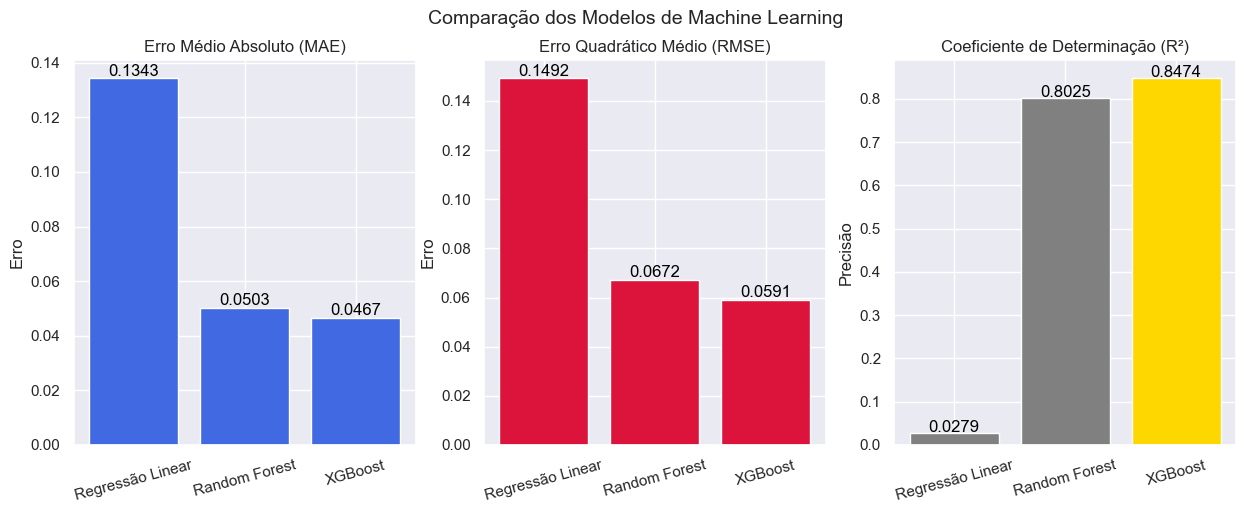

In [74]:
# Concatenar os DataFrames em um único
df_comparacao = pd.concat([
    df_resultados[df_resultados["Modelo"].str.contains("Teste")].assign(Algoritmo="Regressão Linear"),
    df_resultados_rf[df_resultados_rf["Modelo"].str.contains("Teste")].assign(Algoritmo="Random Forest"),
    df_resultados_xgb[df_resultados_xgb["Modelo"].str.contains("Teste")].assign(Algoritmo="XGBoost")
])

# Criar listas com os valores extraídos dos DataFrames
modelos = df_comparacao["Algoritmo"].tolist()
r2 = df_comparacao["R²"].tolist()
rmse = df_comparacao["RMSE"].tolist()
mae = df_comparacao["MAE"].tolist()

# Criar os gráficos
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Gráfico MAE
ax[0].bar(modelos, mae, color="royalblue")
ax[0].set_title("Erro Médio Absoluto (MAE)")
ax[0].set_ylabel("Erro")

# Gráfico RMSE
ax[1].bar(modelos, rmse, color="crimson")
ax[1].set_title("Erro Quadrático Médio (RMSE)")
ax[1].set_ylabel("Erro")

# Identificar o melhor modelo (maior R²) e destacar
melhor_modelo = modelos[r2.index(max(r2))]
colors = ["gray" if m != melhor_modelo else "gold" for m in modelos]

# Gráfico R² com destaque para o melhor modelo
ax[2].bar(modelos, r2, color=colors)
ax[2].set_title("Coeficiente de Determinação (R²)")
ax[2].set_ylabel("Precisão")

# Ajustar rótulos do eixo X para melhor legibilidade
for a in ax:
    a.set_xticklabels(modelos, rotation=15)  # Inclina os rótulos

# Adicionar os valores exatos sobre as barras
for i, v in enumerate(mae):
    ax[0].text(i, v + 0.001, f"{v:.4f}", ha='center', fontsize=12, color="black")

for i, v in enumerate(rmse):
    ax[1].text(i, v + 0.001, f"{v:.4f}", ha='center', fontsize=12, color="black")

for i, v in enumerate(r2):
    ax[2].text(i, v + 0.002, f"{v:.4f}", ha='center', fontsize=12, color="black")

# Definir um título geral para os gráficos
plt.suptitle("Comparação dos Modelos de Machine Learning", fontsize=14)

# Exibir os gráficos
plt.show()


---
## Otimização do Modelo

### Otimização com RandomizedSearchCV

In [75]:
# Definição do modelo base
modelo_xgb = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# Definição dos hiperparâmetros a serem testados
param_grid = {
    'n_estimators': [100, 300, 500, 800],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_lambda': [0, 0.1, 1, 10],
    'reg_alpha': [0, 0.1, 1, 10]
}

# Configuração da busca aleatória
random_search = RandomizedSearchCV(
    estimator=modelo_xgb,
    param_distributions=param_grid,
    n_iter=20,  # Número de combinações a testar
    scoring='neg_mean_absolute_error',  # Métrica de otimização
    cv=3,  # Validação cruzada com 3 divisões
    verbose=2,
    n_jobs=-1
)

# Executar a busca pelos melhores hiperparâmetros
random_search.fit(X_train, y_train)

# Exibir os melhores parâmetros encontrados
print("Melhores hiperparâmetros:", random_search.best_params_)

# Treinar o modelo final com os melhores hiperparâmetros
melhores_params = random_search.best_params_
modelo_xgb_otimizado = XGBRegressor(**melhores_params, objective='reg:squarederror', random_state=42)
modelo_xgb_otimizado.fit(X_train, y_train)

# Fazer previsões
y_train_pred = modelo_xgb_otimizado.predict(X_train)
y_test_pred = modelo_xgb_otimizado.predict(X_test)

# Avaliação do modelo otimizado
result_treino_xgb_opt = avaliar_modelo(y_train, y_train_pred, "XGBoost Otimizado (Treino)")
result_teste_xgb_opt = avaliar_modelo(y_test, y_test_pred, "XGBoost Otimizado (Teste)")

# Criar DataFrame de resultados
df_resultados_xgb_opt = pd.DataFrame([result_treino_xgb_opt, result_teste_xgb_opt])

# Exibir resultados
display(df_resultados_xgb_opt)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Melhores hiperparâmetros: {'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 1, 'n_estimators': 800, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.7}


,Modelo,R²,RMSE,MAE
0,XGBoost Otimizado (Treino),0.9806,0.0224,0.0159
1,XGBoost Otimizado (Teste),0.8507,0.0585,0.0478


In [76]:
# Caminho do arquivo para salvar o modelo
model_path = os.path.join(model_dir, "modelo_xgb_otimizado.pkl")

# Salvar o modelo treinado
with open(model_path, "wb") as f:
    pickle.dump(modelo_xgb_otimizado, f)

print(f"Modelo salvo em: {model_path}")

Modelo salvo em: ../data/models/modelo_xgb_otimizado.pkl


---
# 10.0 Refinamento Final do Modelo

## Análise de Interpretabilidade com SHAP Values

**Objetivo:** Entender quais variáveis mais influenciam o preço dos combustíveis.

In [ ]:
# Converter X_train para float16 para reduzir uso de memória
X_train = X_train.astype('float32')

# Reduzir tamanho da amostra para SHAP (máximo de 5000 amostras para acelerar)
sample_size = min(5000, X_train.shape[0])
X_train_sample = X_train.sample(sample_size, random_state=42)

# Utilizar TreeExplainer diretamente para XGBoost (sem n_jobs)
explainer = shap.TreeExplainer(modelo_xgb_otimizado)
shap_values = explainer.shap_values(X_train_sample)

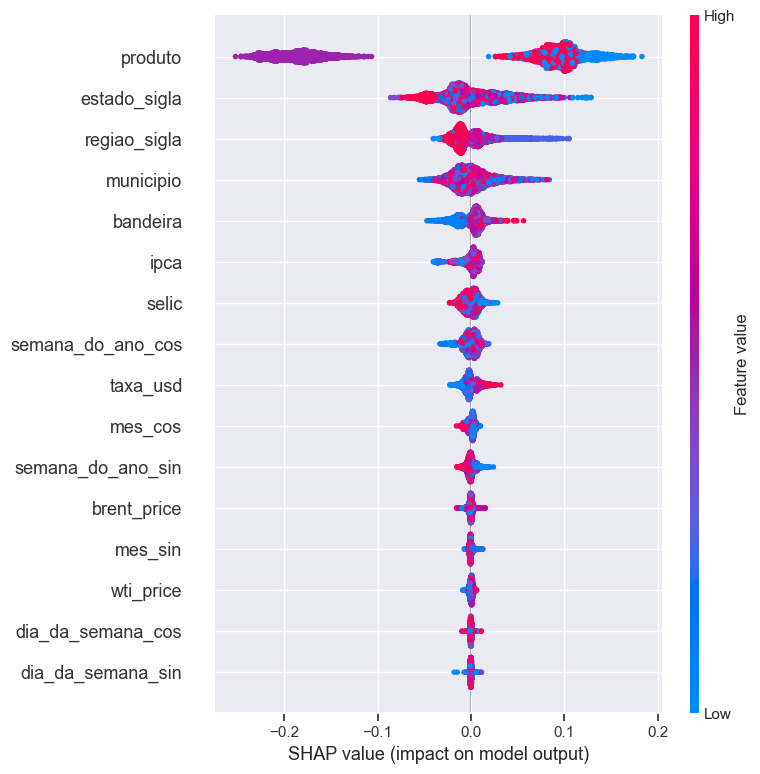

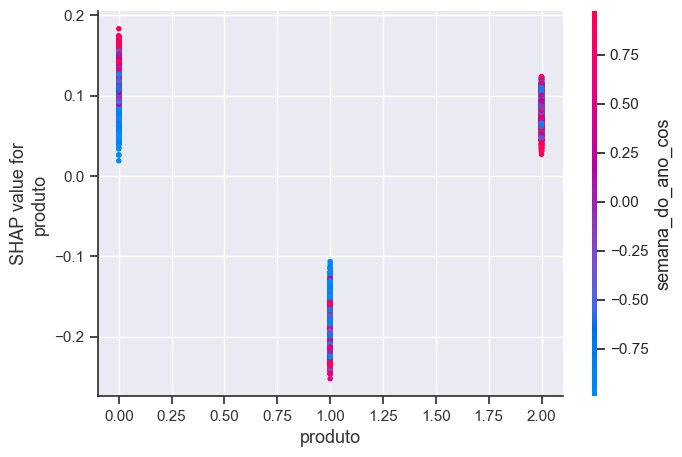

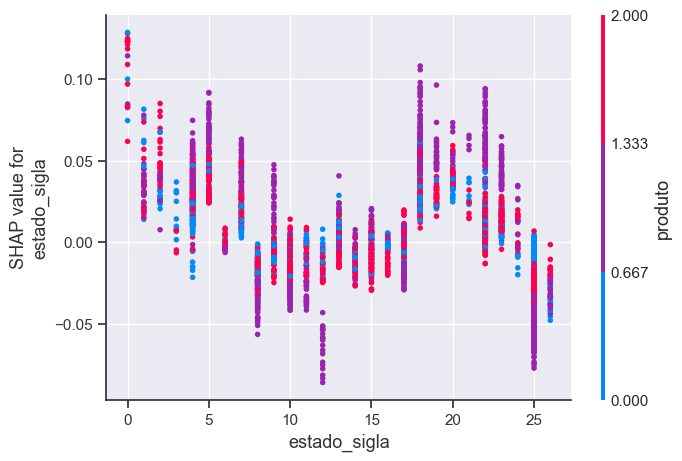

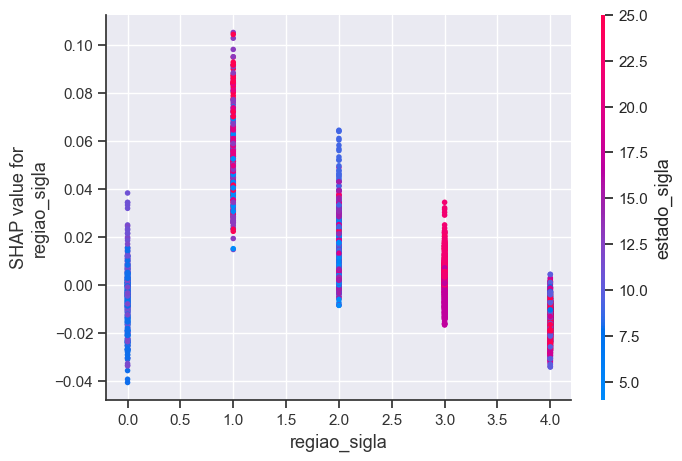

,Feature,SHAP Mean
3,produto,0.1286
1,estado_sigla,0.0246
0,regiao_sigla,0.0148
2,municipio,0.0147
4,bandeira,0.0098
6,ipca,0.0060
9,selic,0.0059
15,semana_do_ano_cos,0.0056
5,taxa_usd,0.0054
11,mes_cos,0.0031


In [78]:
# Gráfico de Importância das Features (Resumo Global)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train_sample)

# Valores Médios de SHAP (Impacto de cada variável)
shap_df = pd.DataFrame({"Feature": X_train_sample.columns, "SHAP Mean": np.abs(shap_values).mean(axis=0)})
shap_df = shap_df.sort_values("SHAP Mean", ascending=False)

# Gráfico de Dependência Parcial para as 3 Variáveis Mais Importantes
top_features = shap_df["Feature"].head(3).tolist()
for feature in top_features:
    shap.dependence_plot(feature, shap_values, X_train_sample)

# Exibir os valores médios de SHAP
display(shap_df)

### 📊 Análise dos Valores SHAP: Impacto das Variáveis na Previsão dos Preços dos Combustíveis  

Os gráficos e a tabela de valores SHAP fornecem **insights sobre a importância de cada variável** no modelo XGBoost, permitindo entender **quais fatores mais influenciam os preços dos combustíveis**.  

---

#### **1. Principais Variáveis que Impactam os Preços (Valores SHAP)**  

**Variável mais influente:** **Produto (0.1286)**  
✅ A **principal variável para previsão dos preços** é o tipo de combustível (**Diesel, Gasolina ou Etanol**).  
✅ Isso faz sentido, pois **cada produto tem sua própria dinâmica de precificação**.  

**Outras variáveis relevantes:**  
✅ **Estado (0.0246) e Região (0.0148)** → O local de venda influencia os preços, devido a **diferenças tributárias, logísticas e concorrência**.  
✅ **Município (0.0147)** → Impacto significativo, reforçando a importância das **variações locais na precificação**.  
✅ **Bandeira (0.0098)** → Postos de bandeira branca e bandeirados possuem diferenças de preços devido a negociações com distribuidoras.  

---

#### **2. Impacto de Indicadores Econômicos (Menor Influência no Curto Prazo)**  

🔸 **IPCA (0.0060) e SELIC (0.0059)** → Pequena influência, indicando que a inflação e os juros **afetam preços de forma indireta**.  
🔸 **Taxa de câmbio (USD/BRL) (0.0054)** → Impacto baixo, sugerindo que o câmbio **não se reflete diretamente no curto prazo**.  
🔸 **Preços do petróleo (Brent e WTI)** → **Correlação muito fraca com os preços dos combustíveis no Brasil**, reforçando que o **repasse das variações do petróleo não ocorre de forma imediata**.  

---

#### **3. Influência da Temporalidade (Ciclo Semanal e Sazonalidade)**  

✅ **Semana do ano (0.0056)** e **Mês (0.0031 - 0.0031)** → Pequena influência da sazonalidade anual, mas não é um fator determinante.  
✅ **Dia da Semana (0.0006 - 0.0006)** → Praticamente insignificante, indicando que **não há uma tendência clara de flutuação diária nos preços**.  

---

#### **Conclusões e Próximos Passos**  

- **O preço dos combustíveis é fortemente influenciado pelo tipo de produto e localização (estado, município e região).**  
- **Fatores macroeconômicos, como câmbio e petróleo, têm impacto reduzido no curto prazo**, possivelmente devido à política de precificação no Brasil.  
- **Sazonalidade e fatores temporais não afetam significativamente os preços**, indicando que a volatilidade do mercado pode estar mais associada a políticas governamentais e demanda local.  

---
# 11.0 Validação Cruzada Temporal (Time Series Cross-Validation)

**Objetivo:** Avaliar a estabilidade do modelo ao longo do tempo.

- Como lidamos com séries temporais, precisamos garantir que o modelo realmente prevê bem novos períodos.
- Vamos aplicar Time Series Cross-Validation, que evita vazamento de dados do futuro para o passado.

In [79]:
# Configurar validação cruzada temporal (5 divisões)
tscv = TimeSeriesSplit(n_splits=5)

# Lista para armazenar resultados
resultados_cv = []

# Rodar validação cruzada
for train_index, test_index in tscv.split(X_train):
    X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

    # Treinar modelo XGBoost otimizado
    modelo_xgb_cv = XGBRegressor(**melhores_params, objective='reg:squarederror', random_state=42)
    modelo_xgb_cv.fit(X_train_cv, y_train_cv)

    # Fazer previsões
    y_pred_cv = modelo_xgb_cv.predict(X_test_cv)

    # Avaliar desempenho
    resultado = avaliar_modelo(y_test_cv, y_pred_cv, f"XGBoost (Fold {len(resultados_cv) + 1})")
    resultados_cv.append(resultado)

# Criar DataFrame com os resultados
df_resultados_cv = pd.DataFrame(resultados_cv)

# Exibir resultados
display(df_resultados_cv)


,Modelo,R²,RMSE,MAE
0,XGBoost (Fold 1),0.5212,0.0864,0.0614
1,XGBoost (Fold 2),0.8795,0.0583,0.0470
2,XGBoost (Fold 3),0.8693,0.0652,0.0535
3,XGBoost (Fold 4),0.9208,0.0503,0.0405
4,XGBoost (Fold 5),0.8469,0.0619,0.0480


- **Fold 4 teve o melhor desempenho geral**, com **R² de 0.9208, RMSE de 0.0503 e MAE de 0.0405**, indicando **baixa margem de erro e alta precisão**.  
- **Fold 2 e Fold 3 também apresentaram bons resultados**, com **R² acima de 0.85** e erros relativamente baixos.  
- **Fold 1 apresentou o menor desempenho (R² = 0.5212)**, sugerindo que pode ter sido um subconjunto mais difícil de prever, possivelmente devido a alguma anomalia nos dados ou maior volatilidade nos preços.  
- **A variação entre os folds sugere que há diferenças na previsibilidade ao longo do tempo**, reforçando a importância de **validação cruzada temporal** para garantir um modelo mais robusto.  


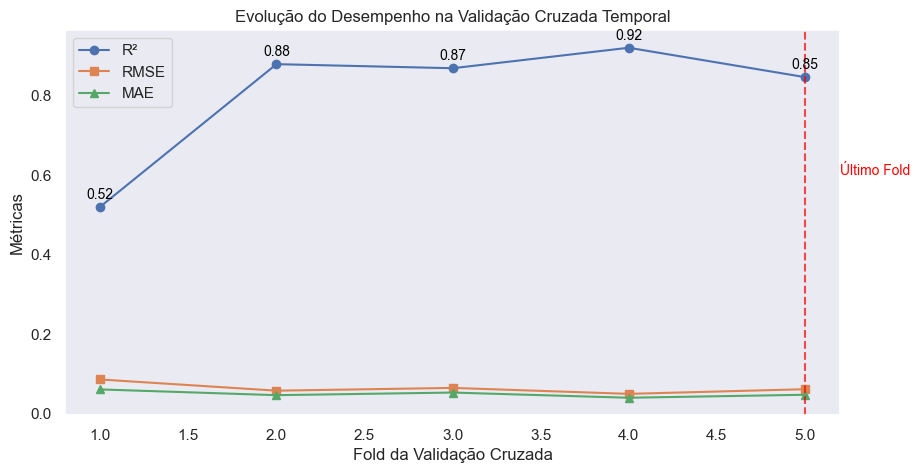

In [80]:
# Criar gráfico para mostrar a variação das métricas nos diferentes folds
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(df_resultados_cv) + 1), df_resultados_cv["R²"], marker="o", label="R²")
plt.plot(range(1, len(df_resultados_cv) + 1), df_resultados_cv["RMSE"], marker="s", label="RMSE")
plt.plot(range(1, len(df_resultados_cv) + 1), df_resultados_cv["MAE"], marker="^", label="MAE")

for i, v in enumerate(df_resultados_cv["R²"]):
    plt.text(i+1, v + 0.02, f"{v:.2f}", ha="center", fontsize=10, color="black")

plt.axvline(x=5, color="red", linestyle="--", alpha=0.7)  # Linha vermelha destacando o Fold 5
plt.text(5.2, 0.6, "Último Fold", color="red", fontsize=10)


plt.xlabel("Fold da Validação Cruzada")
plt.ylabel("Métricas")
plt.title("Evolução do Desempenho na Validação Cruzada Temporal")
plt.legend()
plt.grid()
plt.show()


---
# 12.0 Análises Finais e Conclusão do Projeto

**Avaliação do Erro Percentual Médio (MPE)**

O Erro Percentual Médio (MPE) avalia o quão próximas estão as previsões dos valores reais.

In [81]:
# Aplicar a função para avaliar o erro percentual
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(y_test_pred))
print(f"Erro Percentual Médio (MPE): {mpe:.4f}")

Erro Percentual Médio (MPE): 0.0404


## 12.1 Comparação entre Preços Reais e Previstos

In [82]:
# Criar um DataFrame para análises finais
# Copia os dados de teste originais
df_final = X_test.copy()  

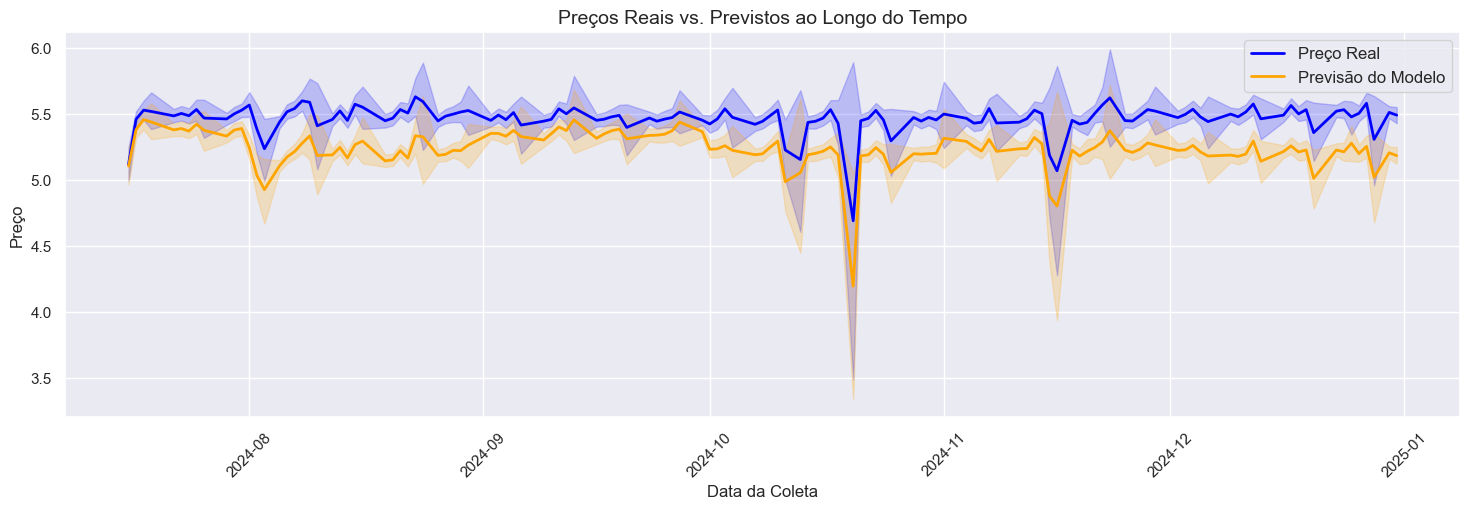

In [83]:
df_final['preco_real'] = np.expm1(y_test)  # Reverter log1p nos preços reais
df_final['previsao'] = np.expm1(y_test_pred)  # Reverter log1p nas previsões

# Adicionar a coluna de data ao df_final se ela existir no dataset original
df_final['data_da_coleta'] = df_final_00.loc[X_test.index, 'data_da_coleta']

plt.figure(figsize=(18, 5))

# Comparação entre preços reais e previstos
sns.lineplot(x=df_final['data_da_coleta'], y=df_final['preco_real'], label="Preço Real", linewidth=2, color="blue")
sns.lineplot(x=df_final['data_da_coleta'], y=df_final['previsao'], label="Previsão do Modelo", linewidth=2, color="orange")

# Melhorando a apresentação
plt.title("Preços Reais vs. Previstos ao Longo do Tempo", fontsize=14)
plt.xlabel("Data da Coleta", fontsize=12)
plt.ylabel("Preço", fontsize=12)
plt.legend(fontsize=12)
plt.xticks(rotation=45)

plt.show()


O gráfico compara os preços reais dos combustíveis (linha azul) com as previsões do modelo (linha laranja), incluindo faixas de incerteza.

Observações:

- O modelo acompanha bem a tendência geral dos preços, mostrando boa estabilidade e baixa variabilidade.
- Existem alguns momentos de subestimação ou superestimação dos preços, especialmente em quedas bruscas.
- Os maiores desvios acontecem em momentos de variações atípicas, indicando que eventos externos (como mudanças na política de preços) podem impactar a precisão.

## 12.2 Avaliação do Desempenho por Produto e Estado

In [84]:
# Carregar os encoders salvos
encoders = pickle.load(open("../data/models/parameter/encoders.pkl", "rb"))

# Carregar os scalers salvos
scalers = pickle.load(open("../data/models/parameter/scalers.pkl", "rb"))

# Criar mapeamento reverso
for col, le in encoders.items():
    df_final[col] = le.inverse_transform(df_final[col])

# Reverter os valores para a escala original
for col, scaler in scalers.items():
    df_final[col] = scaler.inverse_transform(df_final[[col]])

In [85]:
# Criar os dados de análise
df_analise = df_final.copy()

In [86]:
# Calcular MAE e MAPE para cada combinação de estado e produto
df_mae = df_analise.groupby(['estado_sigla', 'produto']).apply(
    lambda x: mean_absolute_error(x['preco_real'], x['previsao'])
).reset_index().rename(columns={0: 'MAE'})

df_mape = df_analise.groupby(['estado_sigla', 'produto']).apply(
    lambda x: mean_absolute_percentage_error(x['preco_real'], x['previsao'])
).reset_index().rename(columns={0: 'MAPE'})

# Calcular a média das previsões por estado e produto
df_previsoes = df_analise.groupby(['estado_sigla', 'produto'])[['previsao']].mean().reset_index()

# Mesclar as métricas no mesmo dataframe
df_resultados = df_previsoes.merge(df_mae, on=['estado_sigla', 'produto'])
df_resultados = df_resultados.merge(df_mape, on=['estado_sigla', 'produto'])

# Definir cenários otimista e pessimista
df_resultados['worst_scenario'] = df_resultados['previsao'] - df_resultados['MAE']
df_resultados['best_scenario'] = df_resultados['previsao'] + df_resultados['MAE']

# Reorganizar colunas para visualização
df_resultados = df_resultados[['estado_sigla', 'produto', 'previsao', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [87]:
# Exibir os estados e produtos com maior MAPE (erro percentual)
df_resultados.sort_values(by='MAPE', ascending=False, inplace=True)

# Exibir a tabela com os 10 estados/produtos com maior erro percentual
print("Erros por Estado e Produto")
display(df_resultados.head(10))

Erros por Estado e Produto


,estado_sigla,produto,previsao,worst_scenario,best_scenario,MAE,MAPE
8,AM,GASOLINA,6.2643,5.4656,7.0630,0.7987,0.1129
65,RR,GASOLINA,5.9385,5.2140,6.6631,0.7246,0.1072
62,RO,GASOLINA,6.2557,5.5612,6.9502,0.6945,0.0987
80,TO,GASOLINA,5.8494,5.2603,6.4386,0.5892,0.0910
7,AM,ETANOL,4.4795,4.0326,4.9263,0.4469,0.0899
2,AC,GASOLINA,6.7809,6.1448,7.4170,0.6361,0.0857
23,ES,GASOLINA,5.8281,5.3375,6.3187,0.4906,0.0774
58,RN,ETANOL,4.8466,4.4956,5.1976,0.3510,0.0743
31,MG,ETANOL,3.9050,3.5897,4.2202,0.3153,0.0736
25,GO,ETANOL,3.8407,3.5322,4.1492,0.3085,0.0733


A tabela mostra os maiores erros absolutos (MAE) e percentuais (MAPE) por estado e produto.

**Estados com maior erro percentual:**
- Amazonas (AM) e Roraima (RR) apresentam os maiores erros para Gasolina, reforçando a dificuldade do modelo em prever corretamente nessas regiões.
- Estados do Sudeste (ES, MG, GO) têm erros menores, indicando maior estabilidade nos preços.

**Possíveis Explicações:**
- Estados do Norte e Nordeste enfrentam desafios logísticos e tributários, tornando os preços mais voláteis e difíceis de prever.
- A Gasolina tem maior erro em estados com menos concorrência ou alta dependência de importação.
- O Etanol é mais volátil devido à influência da safra da cana-de-açúcar, o que pode dificultar previsões em estados com baixa produção interna.

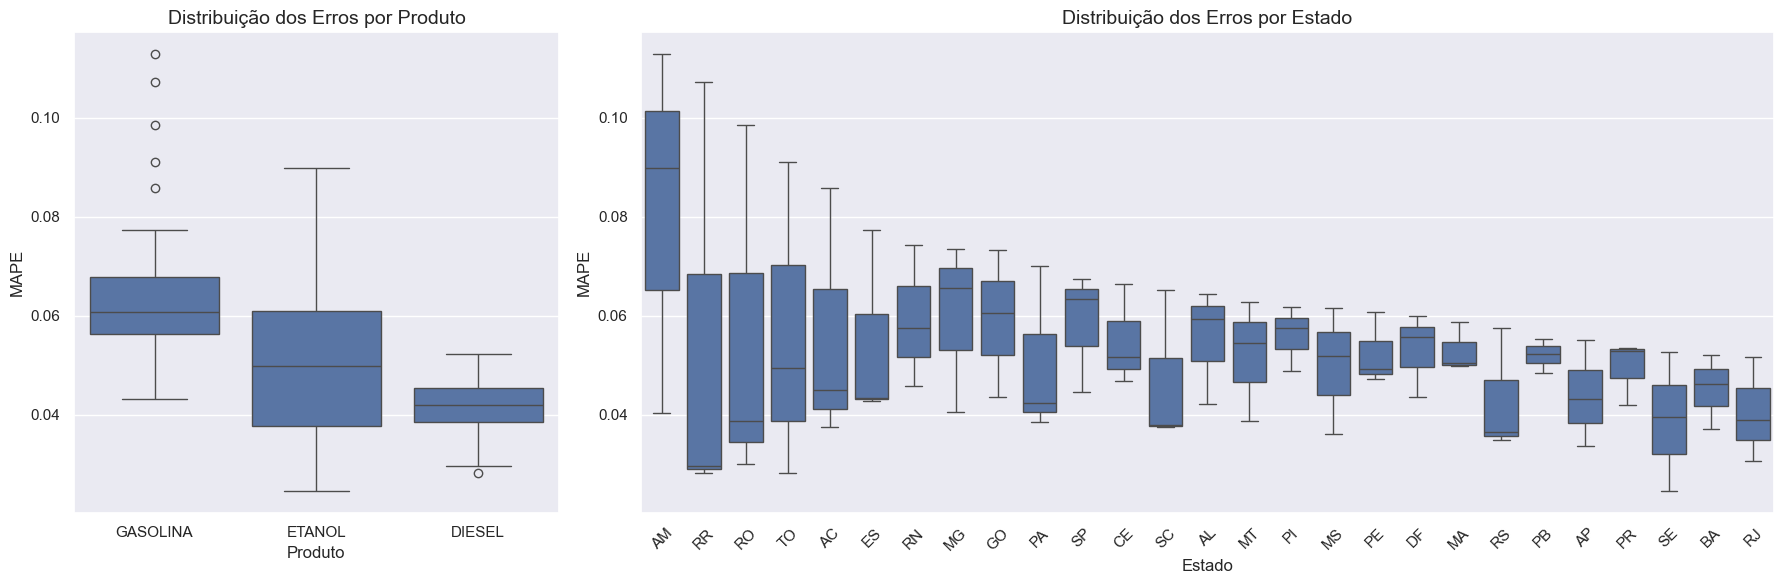

In [88]:
# 📊 Criar a figura com dois gráficos lado a lado
fig, axes = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [0.3, 0.7]})

# Boxplot dos erros por Produto
sns.boxplot(x="produto", y="MAPE", data=df_resultados, ax=axes[0])
axes[0].set_title("Distribuição dos Erros por Produto", fontsize=14)
axes[0].set_xlabel("Produto", fontsize=12)
axes[0].set_ylabel("MAPE", fontsize=12)

# Boxplot dos erros por Estado
sns.boxplot(x="estado_sigla", y="MAPE", data=df_resultados, ax=axes[1])
axes[1].set_title("Distribuição dos Erros por Estado", fontsize=14)
axes[1].set_xlabel("Estado", fontsize=12)
axes[1].set_ylabel("MAPE", fontsize=12)
axes[1].tick_params(axis='x', rotation=45)  # Rotacionar os rótulos dos estados

# Ajustar espaçamento e exibir o gráfico
plt.tight_layout()
plt.show()

**Erros por Produto (Boxplot Esquerdo)**
- Diesel apresenta os menores erros (MAPE mais baixo e menos dispersão), sugerindo que o modelo consegue prever esse combustível com mais precisão.
- Etanol tem maior variabilidade nos erros, possivelmente devido à influência de fatores sazonais (safra e entressafra).
- Gasolina apresenta alguns outliers, indicando que em alguns momentos o modelo teve dificuldades em prever corretamente.

**Erros por Estado (Boxplot Direito)**
- Estados como Amazonas (AM), Roraima (RR) e Rondônia (RO) apresentam erros mais elevados, possivelmente devido a variações regionais nos preços e menor disponibilidade de dados.
- Estados do Sudeste e Sul tendem a ter erros menores, indicando maior previsibilidade nos preços dos combustíveis nessas regiões.

---
# Conclusão e Próximos Passos

### **Principais Resultados**  
O modelo **XGBoost** demonstrou **boa precisão** na previsão dos preços dos combustíveis, com **métricas de erro baixas e estabilidade ao longo do tempo**. Em comparação com modelos mais simples, como **Regressão Linear e Random Forest**, o XGBoost se destacou pela capacidade de capturar variações nos preços sem superajustar os dados.  

### **Impacto e Aplicação**  
A previsão precisa dos preços dos combustíveis pode trazer **benefícios diretos para diferentes públicos**:  
- **Consumidores finais:** Auxilia na escolha do melhor momento para abastecer, reduzindo gastos.  
- **Empresas de transporte e logística:** Permite **planejamento financeiro mais eficiente** e redução do impacto de variações nos preços.  
- **Postos de combustíveis e revendedores:** Facilita **ajustes estratégicos** nos preços, melhorando competitividade.  

### 🚀 **Próximos Passos**  
Para aprimorar ainda mais o projeto, os seguintes passos serão implementados:  
✅ **Otimização da coleta de dados** – Incluir novas variáveis relevantes, como oferta/demanda, estoques e indicadores econômicos mais detalhados.  
✅ **Desenvolvimento de um aplicativo interativo (Streamlit)** – Criar uma interface acessível para que usuários possam visualizar previsões de forma intuitiva.  
✅ **Implementação de alertas automatizados** – Integrar notificações via **API ou Telegram**, permitindo atualizações em tempo real sobre oscilações de preços.  

🔥 **Com essas melhorias, o modelo poderá se tornar uma ferramenta prática e acessível para o acompanhamento dos preços de combustíveis, facilitando a tomada de decisão em diversos setores.**  
